# Do Crop Insurance Premiums Reflect Risk?  
## A Data Analysis Tutorial with USDA FCIC “Summary of Business” Data
by Matthew L. Kelly (https://directory.campbell.edu/people/dr-matthew-kelly/)
  
**Goal:** obtain, clean, describe, and analyze a large panel dataset of county–crop insurance outcomes.

> **Research question:** Are crop insurance premiums (what farmers pay) systematically related to realized losses (indemnities), after accounting for scale, geography, crop composition, and weather?

---

### Background and motivation

Do insurance premiums truly reflect risk? In the United States, insurance for agricultural crop failure risk is overseen and subsidized by a government-chartered entity, much like the Federal Deposit Insurance Corporation (FDIC) does for bank deposit insurance. The USDA’s Federal Crop Insurance Corporation (FCIC) was created shortly after the Great Depression and the Dust Bowl, and was one of many programs associated with President Franklin Roosevelt’s New Deal. The purpose of the program is to assist American farmers, and by extension consumers of agricultural produce by socializing the risk of damage due to weather or diseases. Instead of bearing that responsibility themselves and risking ruin, farmers can pay a known premium to participating insurance companies and receive a payout if disaster strikes. Although premiums are subsidized, private insurance companies are usually responsible for marketing policies to farmers. The FCIC has evolved through the years, expanding in size and scope. The USDA’s Risk Management Agency collects and maintains fairly detailed policy-level data on the program, including information on indemnities, premiums, coverage levels, and subsidies paid. This Python-based tutorial shows readers how to obtain, clean, describe and analyze this large panel dataset using freely available software packages and basic econometric techniques.

You can read more about the history and structure of the FCIC on Wikipedia (https://en.wikipedia.org/wiki/Federal_Crop_Insurance_Corporation). Download the data from the USDA’s Risk Management Agency website. The data we want is found in the **“State/County/Crop Summary of Business”** section, which reports amounts annually for each participating county, and for every crop that is eligible for coverage. Download all these text (`.txt`) files (one for each year) into a single folder on your computer.

### What you need to do before you start

1. Download Python, prefereably with the Anaconda distribution (https://www.anaconda.com/download).
2. **FCIC “State/County/Crop Summary of Business” text files** (one `.txt` per year) downloaded from the USDA RMA website (https://www.rma.usda.gov/tools-reports/summary-of-business/state-county-crop-summary-business).  
3. Data for each year since 1988 have a separate file on the RMA's website. Put all year files for years since 1988 into **one folder**. Data for the years 1948-1988 are contained in a single file, which should be put in another folder.
4. Dollar values for liabilities insured, indemnities paid, and subsidies provided are all reported in nominal terms. For an inflation adjustment section, you’ll need a **FRED API key**.  Request an API key on the FRED python api website (https://fred.stlouisfed.org/docs/api/api_key.html).
5. For the weather section, you’ll need county-year weather data files (format described below). You can obtain these data from 

### Suggested repo layout for GitHub

```
your-repo/
  notebook/
    fcic_tutorial.ipynb
  data/
    raw/
      fcic_sobscc/          # all yearly .txt files
      fcic_pre1988/         # optional: pre-1988 text file(s)
      weather/              # optional: county-year weather files
    processed/
  figures/
  README.md
```

### Roadmap

- Load and stack yearly text files into a single DataFrame  
- Clean identifiers (FIPS codes) and create per-liability rates  
- Exploratory analysis: histograms, scatterplots, time-series growth  
- Inflation-adjust totals (optional)  
- Panel-style analysis and **Fama–MacBeth** style cross-sectional regressions  
- Correlation structure and network visualization (advanced)  
- Merge with weather data and re-run regressions (optional)

> **Note on scale:** this dataset can be large. If you’re memory constrained, start with a subset of years.


## 1. Setup

We’ll use standard packages for our workflow:

- `pandas` for data wrangling
- `matplotlib`/`seaborn` for quick plots
- `statsmodels` for econometric modeling
- `plotly` for interactive county maps (optional)
- `networkx` for network graphs (advanced/optional)

If you’re running this locally, you can install most dependencies in your anaconda terminal with pip:

```bash
pip install pandas numpy matplotlib seaborn statsmodels scipy plotly networkx fredapi
```


In [63]:
# Core
import numpy as np
import pandas as pd

#For calling files from same folder
import glob

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Econometrics and data analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import winsorize
import networkx as nx

# Optional extras
import plotly.express as px
import plotly.io as pio

#FRED Api (for inflation adjustment)
from fredapi import Fred

# Display settings
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)
plt.rcParams["figure.figsize"] = (10, 5)

# If you're in a notebook environment:
%matplotlib inline

## 2. Point to your data folder

Set `folder_path` to the folder where you saved the yearly `.txt` files from the **State/County/Crop Summary of Business** section.

If you also have a pre-1988 file (often provided separately), set that file path as well


In [47]:
folder_path = r"C:\Users\...\USDA FCIC data\original zip files"

folder_path_pre1988 = r'C:\Users\...\48-88\sobscc48-88.txt'

## 3. Load and stack all years

The yearly text files are pipe-delimited (`|`) with no header row. We'll provide column names.

Important wrinkle: the **pre-1988** file (if you have it) often has a different schema (fewer columns). We'll detect schema by counting columns, then harmonize to a common set of variables.

### Columns used in this tutorial

At minimum, we need:

- identifiers: `CommodityYear`, state/county codes, crop code
- scale: `Liabilities`
- cash flows: `Premiums`, `Indemnities`, `Subsidy`
- counts: `PoliciesSoldCount`

We’ll keep additional columns when available.


In [49]:
#########################################
# LOAD DATA (all at once with a for loop)
#########################################
#Create list of all text files in the folder
file_list = glob.glob(folder_path + "/*.txt") 
#Open the first file in folder
df = pd.DataFrame(pd.read_csv(file_list[0], sep='|',header=None, names=['CommodityYear', 'LocationStateCode', 'LocalStateAbbrev', 'LocationCountyCode', 'LocationCountyName', 'CommodityCode', 'CommodityName', 'InsurancePlanCode', 'InsurancePlanName', 'CoverageCategory', 'DeliveryType', 'CoverageLevel', 'PoliciesSoldCount', 'PoliciesEarningPremiumCount', 'PoliciesIndemnifiedCount', 'UnitsEarningPremiumCount', 'UnitsIndemnifiedCount', 'QuantityType', 'NetReportedQuantity', 'EndorsedCompanionAcres', 'Liabilities', 'Premiums', 'Subsidy', 'StatePrivateSubsidy', 'AdditionalSubsidy', 'EFAPremiumDiscount', 'Indemnities', 'LossRatio'])) 
for i in range(1,len(file_list)): 
    data = pd.read_csv(file_list[i], sep='|',header=None, names=['CommodityYear', 'LocationStateCode', 'LocalStateAbbrev', 'LocationCountyCode', 'LocationCountyName', 'CommodityCode', 'CommodityName', 'InsurancePlanCode', 'InsurancePlanName', 'CoverageCategory', 'DeliveryType', 'CoverageLevel', 'PoliciesSoldCount', 'PoliciesEarningPremiumCount', 'PoliciesIndemnifiedCount', 'UnitsEarningPremiumCount', 'UnitsIndemnifiedCount', 'QuantityType', 'NetReportedQuantity', 'EndorsedCompanionAcres', 'Liabilities', 'Premiums', 'Subsidy', 'StatePrivateSubsidy', 'AdditionalSubsidy', 'EFAPremiumDiscount', 'Indemnities', 'LossRatio']) 
    df_btw = pd.DataFrame(data) 
    df = pd.concat([df,df_btw]) 

#add the pre 1988 data
df1948 = pd.read_csv(folder_path_pre1988, sep='|',header=None, names=['CommodityYear', 'LocationStateCode', 'LocalStateAbbrev', 'LocationCountyCode', 'LocationCountyName', 'CommodityCode', 'CommodityName', 'PoliciesSoldCount', 'PoliciesEarningPremiumCount', 'PoliciesIndemnifiedCount', 'UnitsEarningPremiumCount', 'UnitsIndemnifiedCount', 'NetReportedQuantity', 'Liabilities', 'Premiums', 'Subsidy', 'Indemnities', 'LossRatio'])

#Combine into one DataFrame
df = pd.concat([df,df1948])

## 4. Clean identifiers and cast numeric columns

We will:

- Create 5-digit county FIPS codes as strings (`COUNTYCODE`)
- Create a numeric year variable (`YEAR`)
- Convert key money variables to numeric
- Construct rates scaled by liabilities (e.g., `PremLiab = Premiums/Liabilities`)

Why scale by liabilities? It’s a common econometric trick: it makes outcomes comparable across counties/crops of different sizes and helps interpret coefficients as “per dollar insured”.


In [51]:
#Get variable names into a common form so we can merge with weather data
df.sort_values(by='CommodityYear')
df['CountyCode']=df['LocationCountyCode'].astype(str).str.zfill(3)
df['StateCode']=df['LocationStateCode'].astype(str).str.zfill(2)
df['CountyCode2'] = df['StateCode'].astype(str).str.cat(df['CountyCode'].astype(str))
df['COUNTYCODE'] = df['CountyCode2']#.astype(int)
df['YEAR']=df['CommodityYear']
df = df[df['YEAR']<2025]

## 5. Aggregate to a county–crop–year panel

The raw data can include multiple insurance plans and delivery types. A natural econometric unit is **(county, crop, year)**.

We'll create an aggregated panel and compute:

- `IndemLiab = Indemnities / Liabilities` (realized loss rate)
- `PremLiab  = Premiums / Liabilities` (premium rate)
- `SubLiab   = Subsidy / Liabilities` (subsidy rate)
- `SubPrem   = Subsidy / Premiums` (subsidy share of premiums)
- `ProfitLiab = (Premiums - Indemnities) / Liabilities` (insurer-side net rate, ignoring admin costs)


In [53]:
df_aggregated = df.groupby(['COUNTYCODE','CommodityCode','YEAR'])[['Liabilities','Premiums','Indemnities','PoliciesSoldCount','Subsidy']].sum()     #by county and crop
#reset, define some variables
df_agg = df_aggregated.reset_index()
df_agg['Indemnities']=df_agg['Indemnities'].astype(float)
df_agg['Liabilities']=df_agg['Liabilities'].astype(float)
df_agg['Premiums']=df_agg['Premiums'].astype(float)
df_agg['Subsidy']=df_agg['Subsidy'].astype(float)
#Make ratio variables
df_agg['IndemLiab']=df_agg['Indemnities']/df_agg['Liabilities']
df_agg['IndemLiab'].isna().sum()
df_agg['PremLiab']=df_agg['Premiums']/df_agg['Liabilities']
df_agg['PremLiab'].isna().sum()
df_agg['SubLiab']=df_agg['Subsidy']/df_agg['Liabilities']
df_agg['SubLiab'].isna().sum()
df_agg['SubPrem']=df_agg['Subsidy']/df_agg['Premiums']
df_agg['SubPrem'].isna().sum()
df_agg['ProfitLiab'] = (df_agg['Premiums'] - df_agg['Indemnities'])/df_agg['Liabilities']

#Remove impossible entries
df_agg = df_agg.replace([np.inf, -np.inf], np.nan)

## 6. Exploratory plots

A few simple plots can quickly answer “what does this data *look like*?”

- Histograms: are loss rates concentrated near zero? are premiums skewed?
- Scatter: are premiums positively related to losses?
- Growth: how big is the FCIC program, and how has it changed over time?

> These are intentionally “first-pass” visuals. Later we’ll formalize these relationships with regressions.


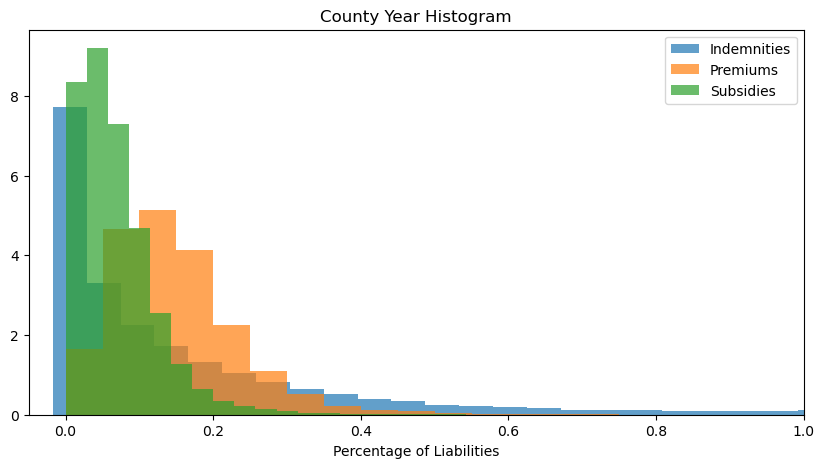

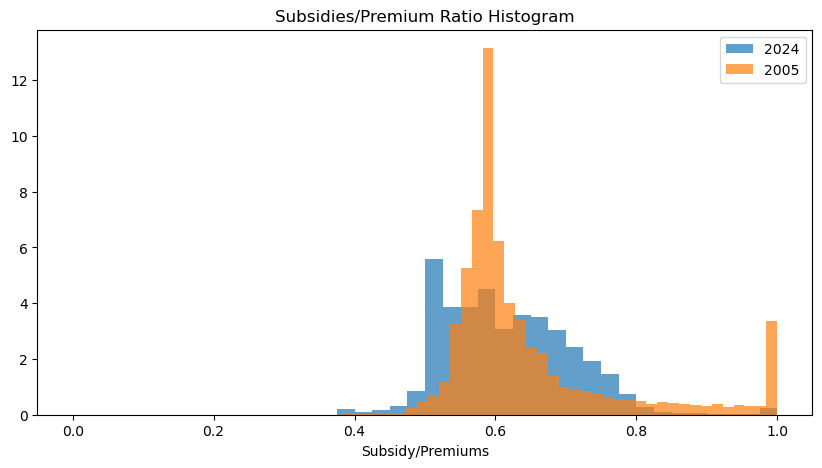

In [57]:
#########################
# HISTOGRAMS
#########################
#Histogram 1
plt.title('County Year Histogram')
plt.hist(df_agg[df_agg['YEAR']>2020]['IndemLiab'],bins=40,density=True,alpha=0.7,label='Indemnities')
plt.hist(df_agg[df_agg['YEAR']>2020]['PremLiab'],bins=40,density=True,alpha=0.7,label='Premiums')
plt.hist(df_agg['SubLiab'],bins=40,density=True,alpha=0.7,label='Subsidies')
plt.xlim(-0.05,1)
plt.xlabel('Percentage of Liabilities')
plt.legend()
plt.show()
#Histogram 2
plt.title('Subsidies/Premium Ratio Histogram')
plt.hist(df_agg[df_agg['YEAR']==2024]['SubPrem'],bins=40,density=True,alpha=0.7,label='2024')
plt.hist(df_agg[df_agg['YEAR']==2005]['SubPrem'],bins=40,density=True,alpha=0.7,label='2005')
plt.xlabel('Subsidy/Premiums')
plt.legend()
plt.show()

In [ ]:
# Scatter: does higher realized loss associate with higher premium rate?
plt.title("Premium rate vs realized loss rate (county–crop aggregates)")
plt.scatter(panel["IndemLiab"], panel["PremLiab"], alpha=0.15)
plt.xlabel("Indemnities/Liabilities")
plt.ylabel("Premiums/Liabilities")
plt.show()

# Sometimes it’s helpful to look at group-level means:
by_county = panel.groupby("COUNTYCODE")[["IndemLiab", "PremLiab"]].mean(numeric_only=True)
by_crop   = panel.groupby("CommodityCode")[["IndemLiab", "PremLiab"]].mean(numeric_only=True)

plt.title("Mean premium rate vs mean loss rate (by county / by crop)")
plt.scatter(by_county["IndemLiab"], by_county["PremLiab"], alpha=0.4, label="County")
plt.scatter(by_crop["IndemLiab"],   by_crop["PremLiab"],   alpha=0.7, label="Crop")
plt.xlabel("Mean Indemnities/Liabilities")
plt.ylabel("Mean Premiums/Liabilities")
plt.legend()
plt.show()


### 6.1 Growth of the program over time

A common panel exercise: aggregate across all cross-sectional units and track time-series trends.

We will plot:

- number of participating counties
- number of eligible crops (commodity codes)
- number of policies sold


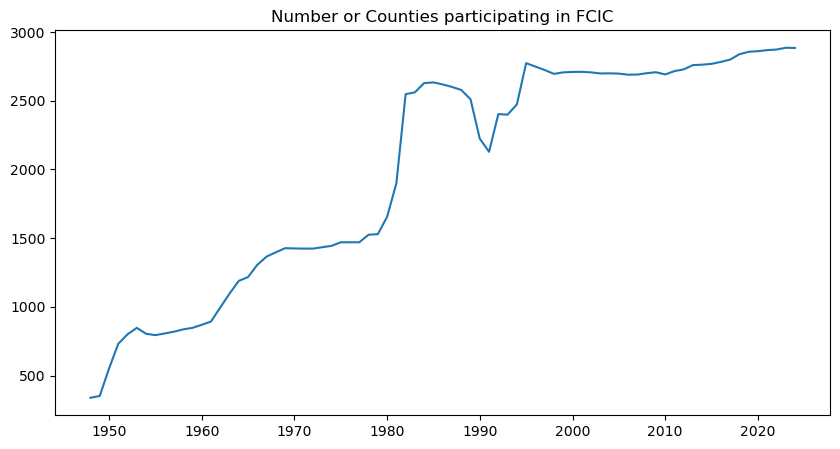

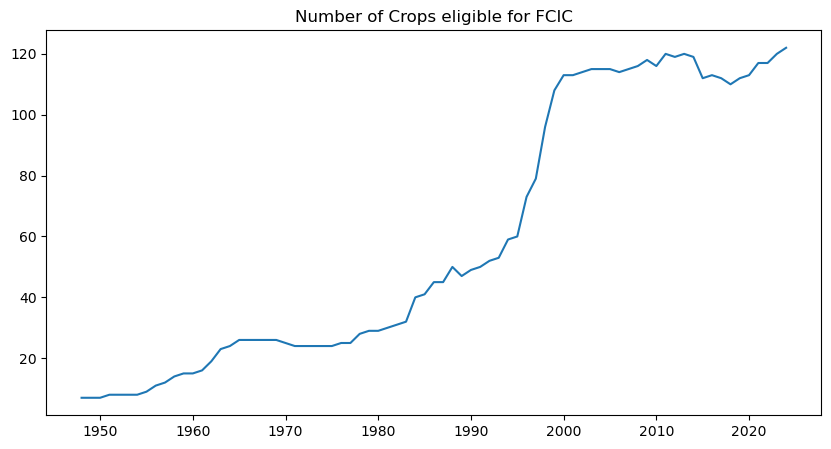

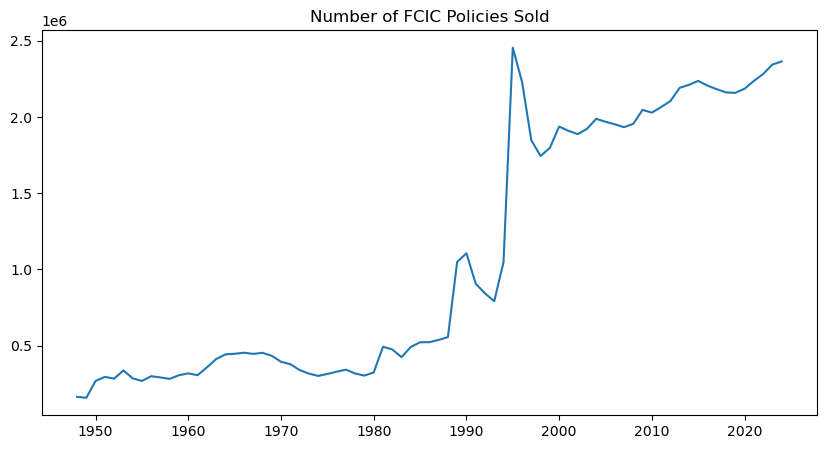

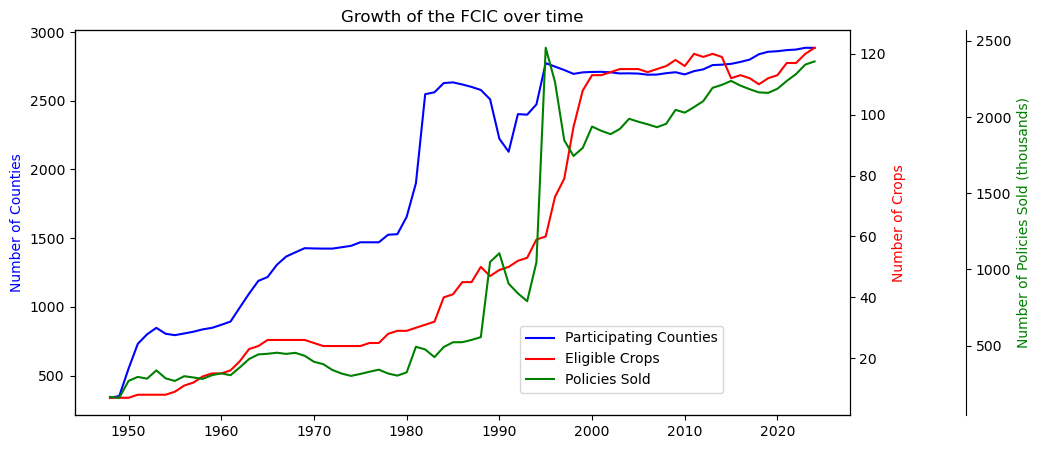

In [91]:
#######################
#GROWTH OF THE PROGRAM
#######################
#Sum across all commodities, all counties
df1 = df.groupby(['CommodityYear'])[['COUNTYCODE']].nunique()
df2 = df1.reset_index()
plt.title('Number or Counties participating in FCIC')
plt.plot(df2['CommodityYear'],df2['COUNTYCODE'])
plt.show()
df3 = df.groupby(['CommodityYear'])[['CommodityCode']].nunique()
df4 = df3.reset_index()
plt.title('Number of Crops eligible for FCIC')
plt.plot(df4['CommodityYear'],df4['CommodityCode'])
plt.show()
df5 = df.groupby(['CommodityYear'])[['PoliciesSoldCount']].sum()
df6 = df5.reset_index()
plt.title('Number of FCIC Policies Sold')
plt.plot(df6['CommodityYear'],df6['PoliciesSoldCount'])
plt.show()
#####
#PLOT all three time series using three y-axes on the same graph
#####
fig, ax1 = plt.subplots()
plt.title('Growth of the FCIC over time')
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax1.plot(df2['CommodityYear'],df2['COUNTYCODE'],color='blue',label='Participating Counties')
ax1.set_ylabel('Number of Counties', color='blue')
ax2.plot(df4['CommodityYear'],df4['CommodityCode'],color='red',label='Eligible Crops')
ax2.set_ylabel('Number of Crops', color='red')
ax3.plot(df6['CommodityYear'],df6['PoliciesSoldCount']/1000,color='green',label='Policies Sold')
ax3.set_ylabel('Number of Policies Sold (thousands)', color='green')
ax3.spines['right'].set_position(('axes', 1.15)) # Adjust 1.2 as needed for desired spacing
fig.legend(loc=(.5,0.125))
plt.show()

## 7. Inflation adjustment (optional)

Nominal dollar series (liabilities, premiums, indemnities) are hard to compare over long horizons. Here we show how to:

1. pull CPI from FRED
2. construct an inflation deflator
3. plot nominal vs real series

**Security note:** do *not* hard-code API keys in a public GitHub repo.  
Instead, set an environment variable:


In [72]:
#########################################################
    #############################
    # Inflation adjustment
    ##############################
#fred api key: ##################
# Replace with your actual API key
fred = Fred(api_key='a16ddb8fc99ae233a512b2ae2af95e26')
# Get the CPI data series
cpi_data = fred.get_series('CPIAUCSL')
# Define the value and years
original_year = 2024    #base year
current_year = 2024     #current year
# Get CPI values for the years
cpi_original = cpi_data.loc[pd.Timestamp(f'{original_year}-01-01')]
cpi_current = cpi_data.resample('YE').mean()
# Calculate the inflation-adjusted value
inflation_adjuster = cpi_current/cpi_original
inflation_adjuster.index = inflation_adjuster.index.strftime('%Y').astype(int)
inflation_adjuster.index.name = 'CommodityYear'
inflation_adjuster.name = 'CPI'
inflation_adjuster = inflation_adjuster.to_frame()

### 8. Total Aggregate Figures

Next, plot the aggregate size of liabilities, premiums, and indemnities in the program. Use the inflation adjustment, and scale these values by policy count and by total liabilities. Finally, let's count how much net surplus the program is making (or losing) after the subsidy spending.

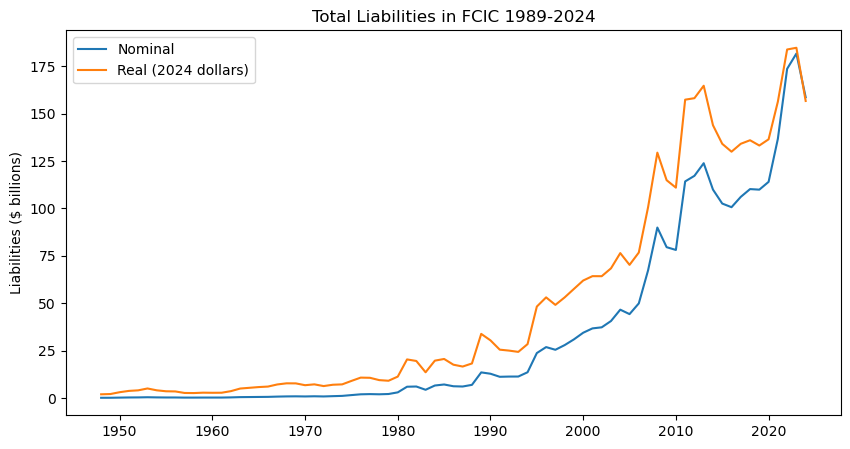

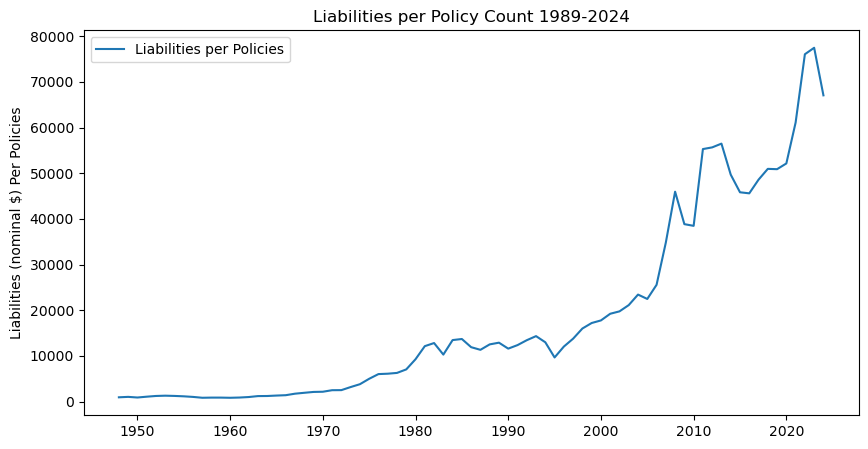

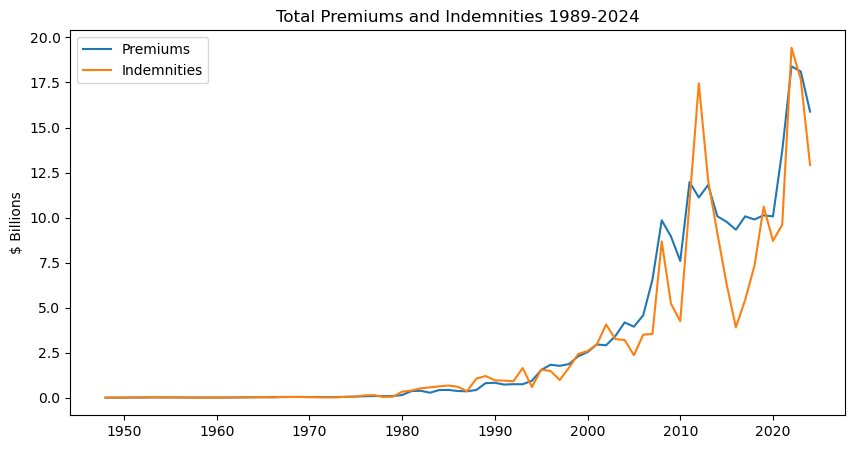

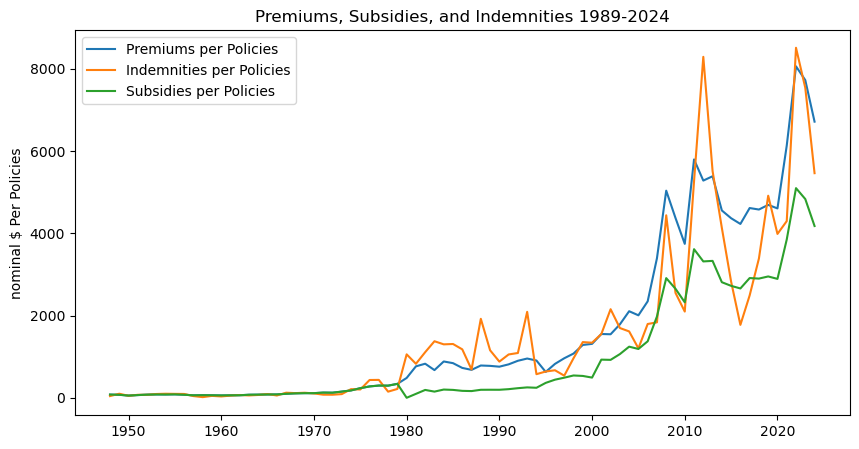

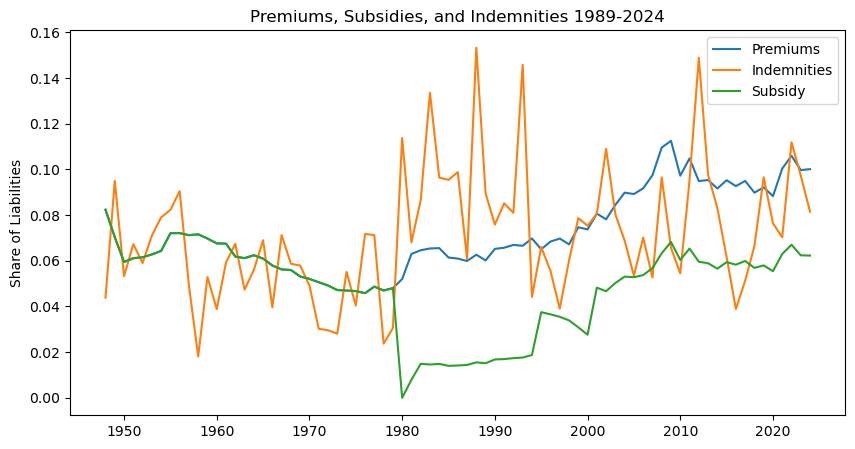

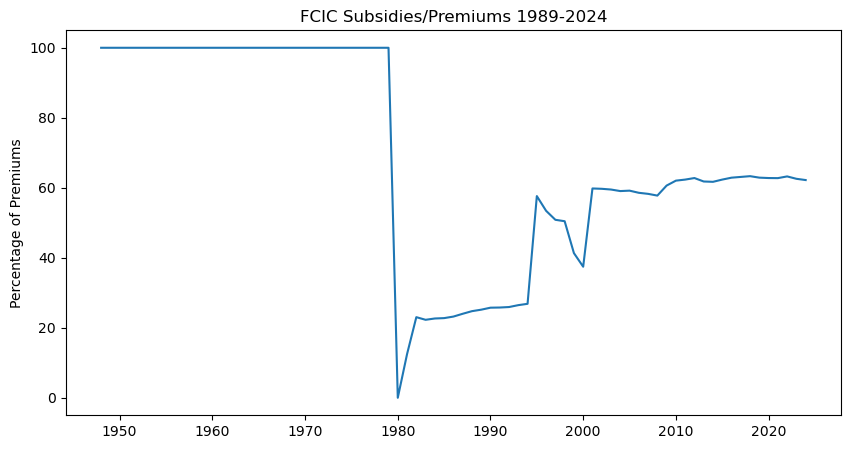

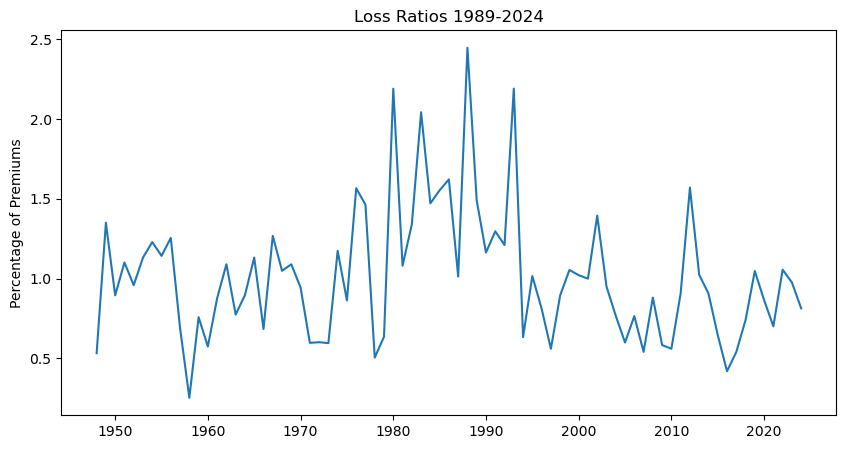

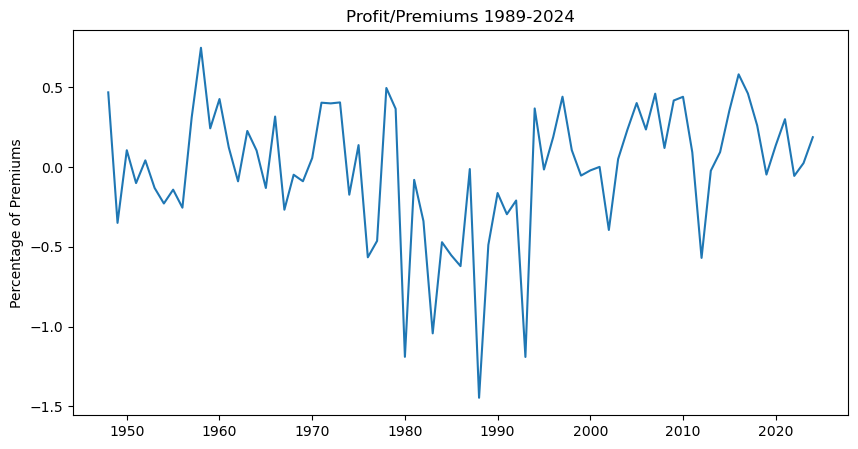

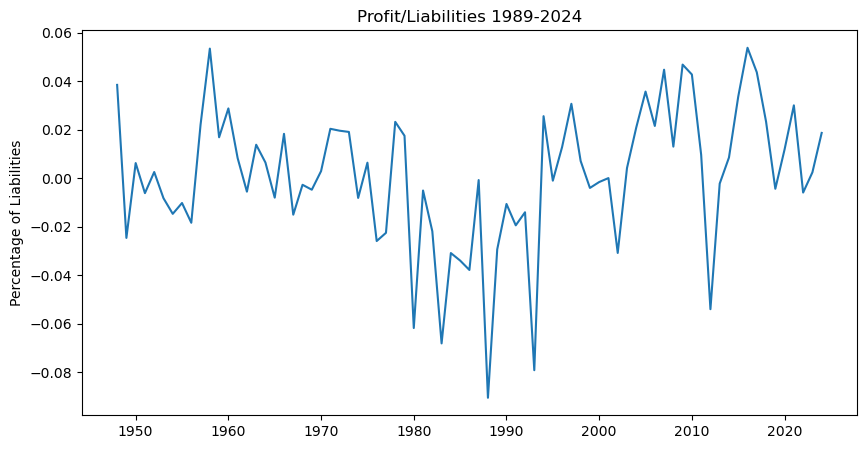

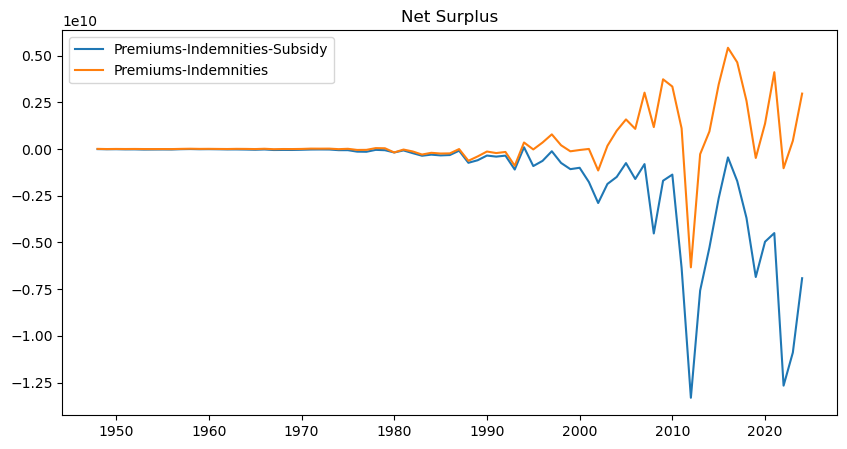

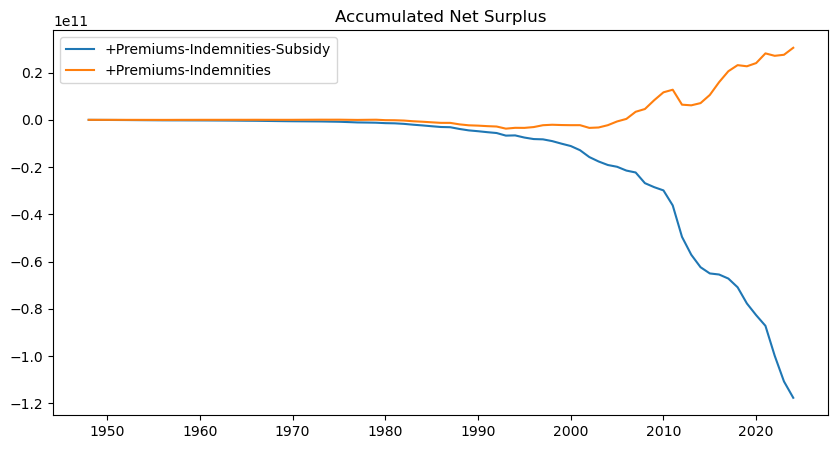

In [105]:
#TOTAL AGGREGATE FIGURES
df1 = df.groupby(['CommodityYear'])[['Liabilities','Premiums','Indemnities','PoliciesSoldCount','Subsidy']].sum()
df2 = df1.reset_index()
df2 = pd.merge(df1,inflation_adjuster,on='CommodityYear',how='inner')
#Time Series PLOT (whole program over time)
#plot 8
plt.title('Total Liabilities in FCIC 1989-2024')
plt.plot(df2['Liabilities']/1000000000,label='Nominal')
plt.plot((1/df2['CPI'])*df2['Liabilities']/1000000000,label='Real (2024 dollars)')
plt.legend()
plt.ylabel('Liabilities ($ billions)')
plt.show()
#plot 2
plt.title('Liabilities per Policy Count 1989-2024')
plt.plot(df2['Liabilities']/df2['PoliciesSoldCount'],label='Liabilities per Policies')
plt.legend()
plt.ylabel('Liabilities (nominal $) Per Policies')
plt.show()
#plot 1
plt.title('Total Premiums and Indemnities 1989-2024')
plt.plot(df2['Premiums']/1000000000,label='Premiums')
plt.plot(df2['Indemnities']/1000000000,label='Indemnities')
plt.legend()
plt.ylabel('$ Billions')
plt.show()
#plot 3
plt.title('Premiums, Subsidies, and Indemnities 1989-2024')
plt.plot(df2['Premiums']/df2['PoliciesSoldCount'],label='Premiums per Policies')
plt.plot(df2['Indemnities']/df2['PoliciesSoldCount'],label='Indemnities per Policies')
plt.plot(df2['Subsidy']/df2['PoliciesSoldCount'],label='Subsidies per Policies')
plt.legend()
plt.ylabel('nominal $ Per Policies')
plt.show()
#plot 5
plt.title('Premiums, Subsidies, and Indemnities 1989-2024')
plt.plot(df2['Premiums']/df2['Liabilities'],label='Premiums')
plt.plot(df2['Indemnities']/df2['Liabilities'],label='Indemnities')
plt.plot(df2['Subsidy']/df2['Liabilities'],label='Subsidy')
plt.ylabel('Share of Liabilities')
plt.legend()
plt.show()
#plot 4
plt.title('FCIC Subsidies/Premiums 1989-2024')
plt.plot(100*df2['Subsidy']/df2['Premiums'])
plt.ylabel('Percentage of Premiums')
plt.show()
#plot 4
plt.title('Loss Ratios 1989-2024')
plt.plot(df2['Indemnities']/df2['Premiums'])
plt.ylabel('Percentage of Premiums')
plt.show()
#plot 4
plt.title('Profit/Premiums 1989-2024')
plt.plot((df2['Premiums']-df2['Indemnities'])/df2['Premiums'])
plt.ylabel('Percentage of Premiums')
plt.show()
#plot 4
plt.title('Profit/Liabilities 1989-2024')
plt.plot((df2['Premiums']-df2['Indemnities'])/df2['Liabilities'])
plt.ylabel('Percentage of Liabilities')
plt.show()
#plot 6
plt.title('Net Surplus')
plt.plot(df2['Premiums']-df2['Indemnities']-df2['Subsidy'],label='Premiums-Indemnities-Subsidy')
plt.plot(df2['Premiums']-df2['Indemnities'],label='Premiums-Indemnities')
plt.legend()
plt.show()
#plot 7
plt.title('Accumulated Net Surplus')
plt.plot(df2['Premiums'].cumsum()-df2['Indemnities'].cumsum()-df2['Subsidy'].cumsum(),label='+Premiums-Indemnities-Subsidy')
plt.plot(df2['Premiums'].cumsum()-df2['Indemnities'].cumsum(),label='+Premiums-Indemnities')
plt.legend()
plt.show()

### 9. Calculate a few Statistics

Caluclate:
- net costs
- statistical moments (mean, standard deviation, skewness, and coefficient of variation for indemnities, premiums, subsidies, and loss ratios

In [76]:
################################
#CALCULATE Totals and Statistics
################################
#Net Cost figures
print('Net Cost of FCIC program (Cumulative 1989-2024): $' + str((df2['Premiums'].cumsum()-df2['Indemnities'].cumsum()-df2['Subsidy'].cumsum()).tail(1)/1000000000) + ' Billion')
print('Net Cost of FCIC program (2024): $' + str((df2['Premiums']-df2['Indemnities']-df2['Subsidy']).tail(1)/1000000000) + ' Billion')
#Indmenities
print('Mean of Indemnities/Liabilites:' + str((df2['Indemnities']/df2['Liabilities']).mean()))
print('St.Dev of Indemnities/Liabilites:' + str((df2['Indemnities']/df2['Liabilities']).std()))
print('Skewness of Indemnities/Liabilites:' + str((df2['Indemnities']/df2['Liabilities']).skew()))
print('Coefficient of Variation of Indemnities/Liabilites:' + str((df2['Indemnities']/df2['Liabilities']).std()/(df2['Indemnities']/df2['Liabilities']).mean()))
#Premiums
print('Mean of Premiums/Liabilites:' + str((df2['Premiums']/df2['Liabilities']).mean()))
print('St.Dev of Premiums/Liabilites:' + str((df2['Premiums']/df2['Liabilities']).std()))
print('Skewness of Premiums/Liabilites:' + str((df2['Premiums']/df2['Liabilities']).skew()))
print('Coefficient of Variation of Premiums/Liabilites:' + str((df2['Premiums']/df2['Liabilities']).std()/(df2['Premiums']/df2['Liabilities']).mean()))
#Subsidy
print('Mean of Subsidy/Liabilites:' + str((df2['Subsidy']/df2['Liabilities']).mean()))
print('St.Dev of Subsidy/Liabilites:' + str((df2['Subsidy']/df2['Liabilities']).std()))
print('Skewness of Subsidy/Liabilites:' + str((df2['Subsidy']/df2['Liabilities']).skew()))
print('Coefficient of Variation of Subsidy/Liabilites:' + str((df2['Subsidy']/df2['Liabilities']).std()/(df2['Subsidy']/df2['Liabilities']).mean()))
#Loss Ratio
print('Mean of Loss Ratio:' + str((df2['Indemnities']/df2['Premiums']).mean()))
print('St.Dev of Loss Ratio:' + str((df2['Indemnities']/df2['Premiums']).std()))
print('Skewness of Loss Ratio:' + str((df2['Indemnities']/df2['Premiums']).skew()))
print('Coefficient of Variation of Loss Ratio:' + str((df2['Indemnities']/df2['Premiums']).std()/(df2['Indemnities']/df2['Premiums']).mean()))

Net Cost of FCIC program (Cumulative 1989-2024): $CommodityYear
2024   -117.684021
dtype: float64 Billion
Net Cost of FCIC program (2024): $CommodityYear
2024   -6.915552
dtype: float64 Billion
Mean of Indemnities/Liabilites:0.07101517540773025
St.Dev of Indemnities/Liabilites:0.027816499601606762
Skewness of Indemnities/Liabilites:0.7819692897728988
Coefficient of Variation of Indemnities/Liabilites:0.391697963736619
Mean of Premiums/Liabilites:0.07209584800805743
St.Dev of Premiums/Liabilites:0.017582304057846124
Skewness of Premiums/Liabilites:0.523140622491424
Coefficient of Variation of Premiums/Liabilites:0.2438740169320309
Mean of Subsidy/Liabilites:0.04826830342550691
St.Dev of Subsidy/Liabilites:0.01957914177690791
Skewness of Subsidy/Liabilites:-0.8192801142613018
Coefficient of Variation of Subsidy/Liabilites:0.40563144729386746
Mean of Loss Ratio:1.0133042754218264
St.Dev of Loss Ratio:0.4169287140018457
Skewness of Loss Ratio:1.1950710934817286
Coefficient of Variation of 

## 10. Stationarity checks (ADF and KPSS)

Econometrics students often ask: “Can I treat this time series as stationary?” This is an especially interesting question for this data, since a trend or change in volatility of insurance payouts and premiums would presumably indicate a change in climate risk, as measured by crop damage due to storms, draughts, and other natural disasters.

Here we run both:

- **ADF test** (null: non-stationary)
- **KPSS test** (null: trend-stationary)

We'll apply them to an aggregate loss-rate series:
\[
\text{LossRate}_t = \frac{\text{Indemnities}_t}{\text{Liabilities}_t}.
\]

> Note: using both tests is common because they have opposite null hypotheses.


ADF Statistic: -6.158539076409553
p-value: 7.268274326903299e-08
Critical Values:
	1%: -3.5194805351545413
	5%: -2.9003945086747343
	10%: -2.5874984279778395
Reject the null hypothesis (H0). The time series is stationary.


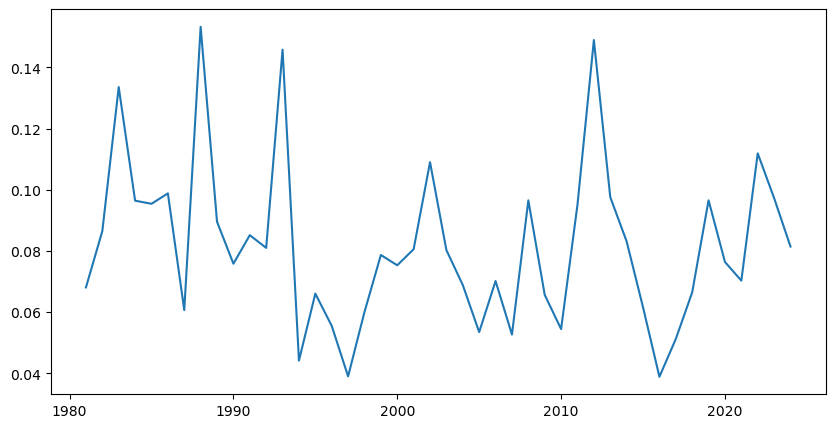

KPSS Statistic: 0.09595060027738135
p-value: 0.1
Lags Used: 1
Critical Values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
Fail to reject the null hypothesis (H0). The time series is trend-stationary.


C:\Users\mlkelly0906\AppData\Local\Temp\ipykernel_18852\2393543504.py:32: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(df2[df2.index>1980]['Indemnities']/df2[df2.index>1980]['Liabilities'], regression='ct', nlags='auto') # 'c' for constant, 'ct' for constant and trend


In [107]:
###############
#AUGMENTED DICKY-FULLY TEST of stationarity
###############
#Question: is the data stationary?
from statsmodels.tsa.stattools import adfuller
# Assuming 'time_series_data' is your pandas Series or array
# Example: time_series_data = pd.Series([1, 2, 3, 4, 5])
result = adfuller(df2['Indemnities']/df2['Liabilities'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

# Interpretation
if result[1] <= 0.05:
    print("Reject the null hypothesis (H0). The time series is stationary.")
else:
    print("Fail to reject the null hypothesis (H0). The time series is non-stationary.")

###############
#KPSS TEST
###############

plt.plot(df2[df2.index>1980]['Indemnities']/df2[df2.index>1980]['Liabilities'])
plt.show()

#Question: is the data stationary?
from statsmodels.tsa.stattools import kpss
# Assuming 'time_series_data' is your pandas Series or array
# Example: time_series_data = pd.Series([1, 2, 3, 4, 5])
result = kpss(df2[df2.index>1980]['Indemnities']/df2[df2.index>1980]['Liabilities'], regression='ct', nlags='auto') # 'c' for constant, 'ct' for constant and trend
print('KPSS Statistic:', result[0])
print('p-value:', result[1])
print('Lags Used:', result[2])
print('Critical Values:')
for key, value in result[3].items():
    print(f'\t{key}: {value}')

# Interpretation
if result[1] <= 0.05:
    print("Reject the null hypothesis (H0). The time series is non-stationary.")
else:
    print("Fail to reject the null hypothesis (H0). The time series is trend-stationary.")

##############################
# *** Notes on ADF and KPSS tests ****
##############################
#1. ADF: Null hypothesis: non-stationary. Rejecting H0 implies stationarity.
#2. KPSS: Null hypothesis: trend-stationary. Rejecting H0 implies non-stationarity.
#It is often recommended to use both tests, as they can provide complementary 
#insights into the stationarity of a time series. For instance, 
#if ADF suggests stationarity and KPSS suggests non-stationarity, the series might be trend-stationary.

# in the above, I limit the sample to post-1990, when major reforms were put in place in the FCIC program.
##############################

Notice that both tests indicate that the data are stationary...which suggests that climate change is not impacting insurance payouts.

### 11. Additional Histograms

The histograms below are usued to visualize the distribution of size across crops and counties. Some counties and crops have a lot of insured liabilities and/or collect a lot of premiums. Some have fewer.

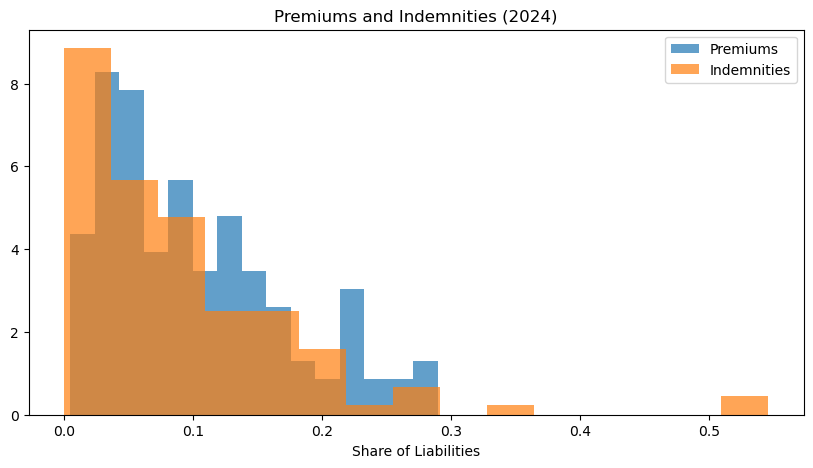

C:\Users\mlkelly0906\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


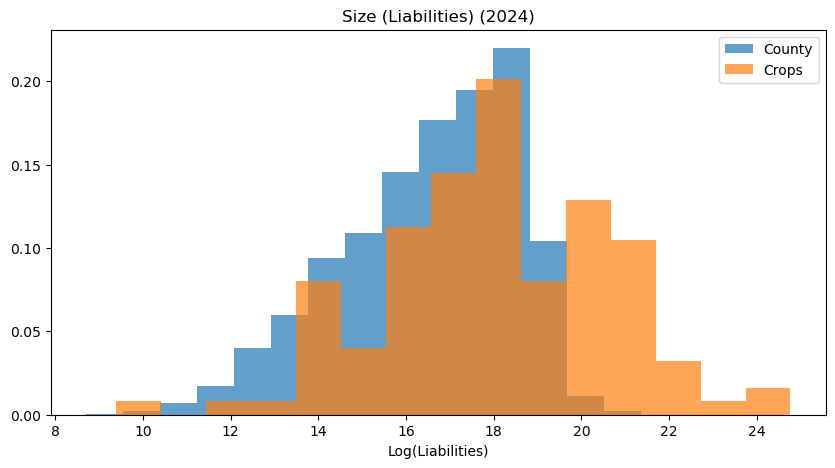

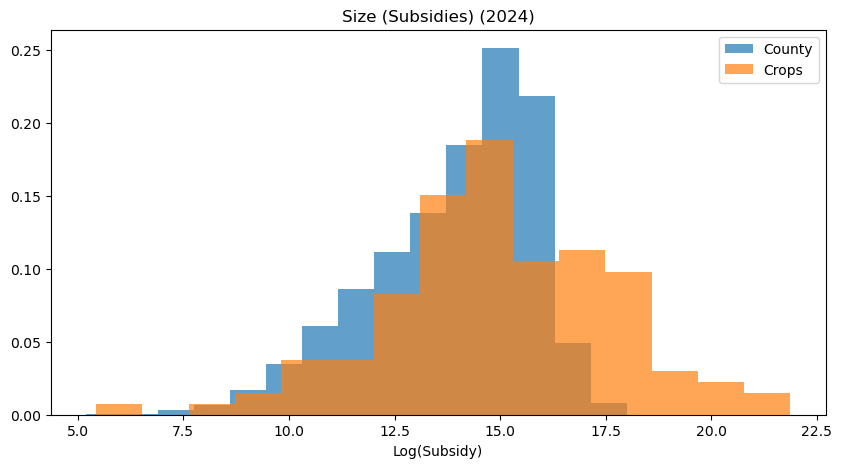

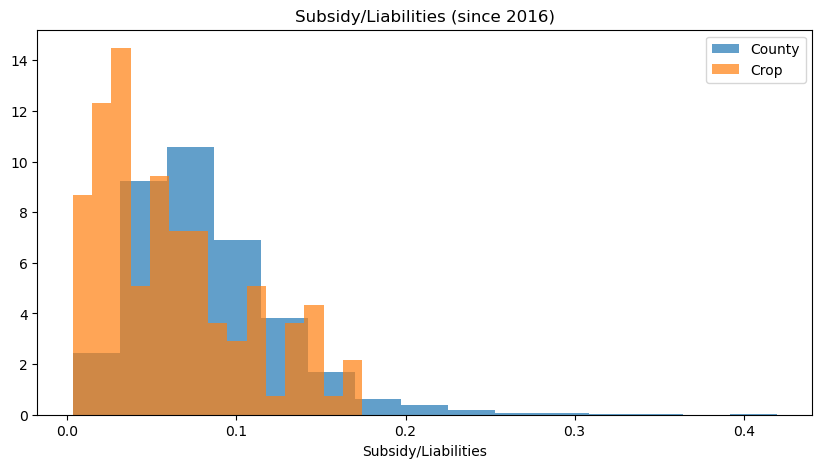

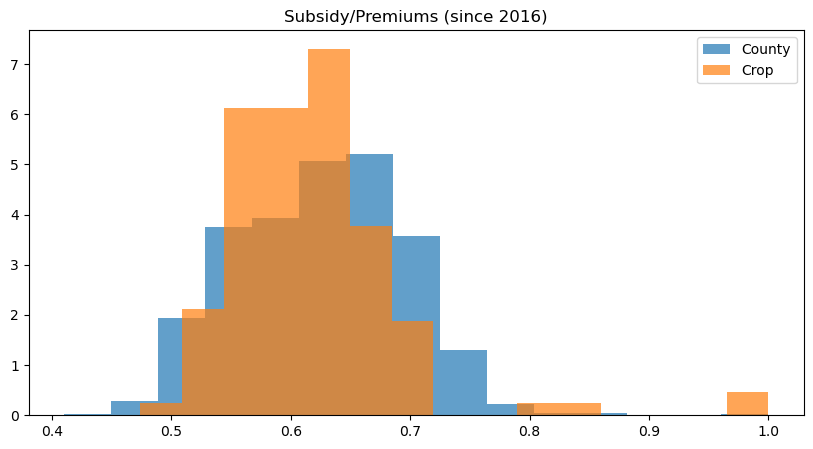

In [110]:
startyear=2023
df3 = df[df['CommodityYear']>startyear].groupby(['COUNTYCODE'])[['Liabilities','Premiums','Indemnities','Subsidy']].sum()
df4 = df3.reset_index()
startyear=2023
df5 = df[df['CommodityYear']>startyear].groupby(['CommodityCode'])[['Liabilities','Premiums','Indemnities','Subsidy']].sum()
df6 = df5.reset_index()
#plot historgram 2
plt.title('Premiums and Indemnities (2024)')
plt.hist(df6['Premiums']/df6['Liabilities'],bins=15,alpha=0.7,density=True,label='Premiums')
plt.hist(df6['Indemnities']/df6['Liabilities'],bins=15,alpha=0.7,density=True,label='Indemnities')
plt.legend()
plt.xlabel('Share of Liabilities')
plt.show()
#plot historgram 3
plt.title('Size (Liabilities) (2024)')
plt.hist(np.log(df4['Liabilities']).replace([np.inf, -np.inf], np.nan).dropna(),bins=15,density=True,alpha=0.7,label='County')
plt.hist(np.log(df6['Liabilities']).replace([np.inf, -np.inf], np.nan).dropna(),bins=15,density=True,alpha=0.7,label='Crops')
plt.xlabel('Log(Liabilities)')
plt.legend()
plt.show()
#plot historgram 4
plt.title('Size (Subsidies) (2024)')
plt.hist(np.log(df4['Subsidy']).replace([np.inf, -np.inf], np.nan).dropna(),bins=15,density=True,alpha=0.7,label='County')
plt.hist(np.log(df6['Subsidy']).replace([np.inf, -np.inf], np.nan).dropna(),bins=15,density=True,alpha=0.7,label='Crops')
plt.xlabel('Log(Subsidy)')
plt.legend()
plt.show()
#plot historgram 7
plt.title('Subsidy/Liabilities (since 2016)')
plt.hist(df4['Subsidy']/df4['Liabilities'],bins=15,density=True,alpha=0.7,label='County')
plt.hist(df6['Subsidy']/df6['Liabilities'],bins=15,density=True,alpha=0.7,label='Crop')
plt.xlabel('Subsidy/Liabilities')
plt.legend()
plt.show()
#plot historgram 2
plt.title('Subsidy/Premiums (since 2016)')
plt.hist(df4['Subsidy']/df4['Premiums'],bins=15,density=True,alpha=0.7,label='County')
plt.hist(df6['Subsidy']/df6['Premiums'],bins=15,density=True,alpha=0.7,label='Crop')
plt.legend()
plt.show()

### Coverage Level and Premiums
Another empirical observation we can make is that counties where the coverage level is higher are counties where premiums are higher as a share of liabilities.

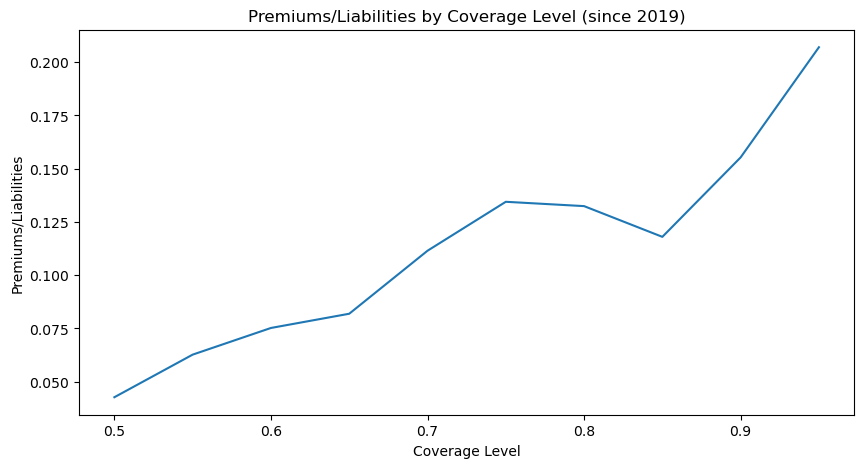

In [171]:
###############################################
#COVERAGE LEVEL (increases with premiums; risk)
###############################################
#Sum across all commodities, all counties
df7 = df[df['CommodityYear']>2019].groupby(['CoverageLevel'])[['Liabilities','Premiums','Indemnities','Subsidy']].median()
df8 = df7.reset_index()
#plot
plt.title('Premiums/Liabilities by Coverage Level (since 2019)')
plt.plot(df8['CoverageLevel'],df8['Premiums']/df8['Liabilities'])
plt.xlabel('Coverage Level')
plt.ylabel('Premiums/Liabilities')
plt.show()

## 12. Risk and Insurance Premiums
If the insurance policies in the FCIC program are fairly priced, then riskier crops ought to cost more to insure. The premiums should be higher for crops and counties with greater risk. 
### 12.1 Scatter plots and simple correlations

The following scatter plots enable us to visualize the relationship.

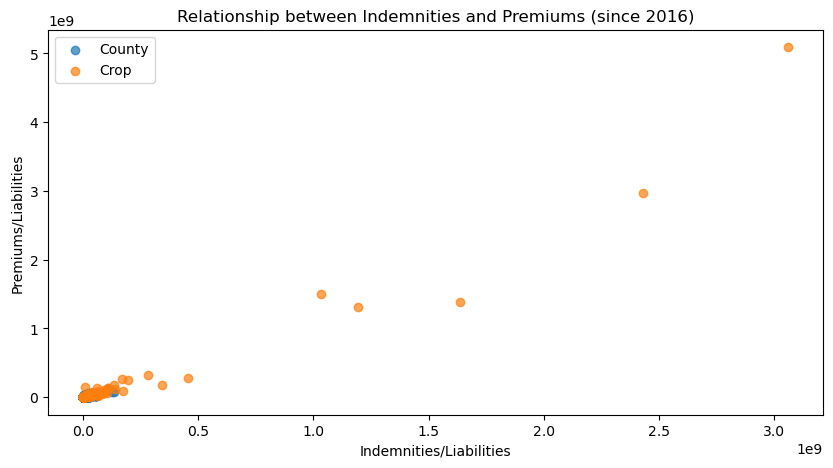

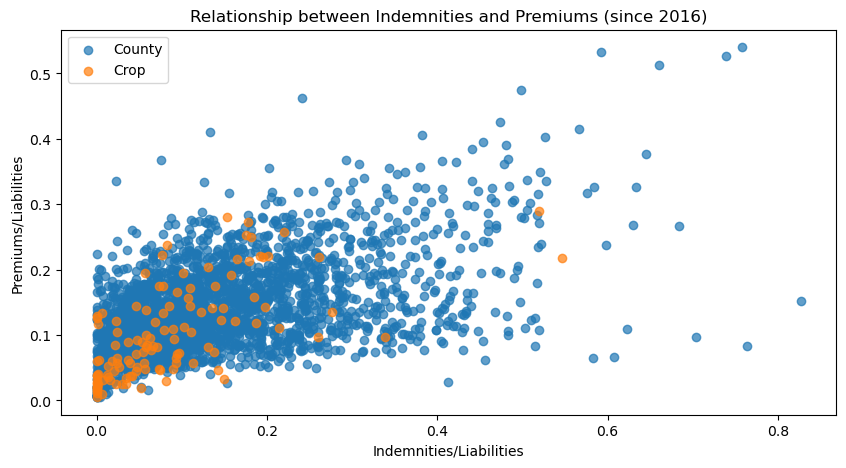

In [116]:
#SCATTER PLOTS
plt.title('Relationship between Indemnities and Premiums (since 2016)')
plt.scatter(df4['Indemnities'],df4['Premiums'],alpha=0.7,label='County')
plt.scatter(df6['Indemnities'],df6['Premiums'],alpha=0.7,label='Crop')
plt.legend()
plt.xlabel('Indemnities/Liabilities')
plt.ylabel('Premiums/Liabilities')
plt.show()
#Scatter Plot: indemnities and premiums
plt.title('Relationship between Indemnities and Premiums (since 2016)')
plt.scatter(df4['Indemnities']/df4['Liabilities'],df4['Premiums']/df4['Liabilities'],alpha=0.7,label='County')
plt.scatter(df6['Indemnities']/df6['Liabilities'],df6['Premiums']/df6['Liabilities'],alpha=0.7,label='Crop')
plt.legend()
plt.xlabel('Indemnities/Liabilities')
plt.ylabel('Premiums/Liabilities')
plt.show()


And now let us calculate simple correlations and covariances to assign a number to this relationship between insurance payouts and insurance premiums. Notice that the correlations are lower (but still positive and fairly large) when scaled by liabilities, and also larger when the unit of analysis is crops rather than counties. The positive and large correlation estimates suggest that the FCIC program has insurance policies with premiums that accurately reflect the risks.

In [151]:
#CORRELATIONS AND COVARIANCES

##Counties
###Raw
print('Correlation between Indemnities and Premiums (across counties): ' + str(np.corrcoef(df4['Indemnities'],df4['Premiums'])[0][1]))
print('covariance matrix of indemnities and premiums (across counties): ' + str(np.cov(df4['Indemnities'],df4['Premiums'])))
###Scaled by Liabilities
print('Correlation between Indemnities and Premiums (across counties, scaled by liabilities): ' + str(np.corrcoef((df4['Indemnities']/df4['Liabilities']).dropna(),(df4['Premiums']/df4['Liabilities']).dropna())[0][1]))
print('covariance matrix of indemnities and premiums (across counties, scaled by liabilities): ' + str(np.cov((df4['Indemnities']/df4['Liabilities']).dropna(),(df4['Premiums']/df4['Liabilities']).dropna())))

##Crops
###Raw
print('Correlation between Indemnities and Premiums (across crops): ' + str(np.corrcoef(df6['Indemnities'],df6['Premiums'])[0][1]))
print('covariance matrix of indemnities and premiums (across crops): ' + str(np.cov(df6['Indemnities'],df6['Premiums'])))
###Scaled by liabilities
print('Correlation between Indemnities and Premiums (across crops, scaled by liabilities): ' + str(np.corrcoef((df6['Indemnities']/df6['Liabilities']).dropna(),(df6['Premiums']/df6['Liabilities']).dropna())[0][1]))
print('covariance matrix of indemnities and premiums (across crops, scaled by liabilities): ' + str(np.cov((df6['Indemnities']/df6['Liabilities']).dropna(),(df6['Premiums']/df6['Liabilities']).dropna())))

Correlation between Indemnities and Premiums (across counties): 0.7794508315876949
covariance matrix of indemnities and premiums (across counties): [[6.96858492e+13 5.11886783e+13]
 [5.11886783e+13 6.18907557e+13]]
Correlation between Indemnities and Premiums (across counties, scaled by liabilities): 0.5687549996436143
covariance matrix of indemnities and premiums (across counties, scaled by liabilities): [[0.01437322 0.0046649 ]
 [0.0046649  0.00468037]]
Correlation between Indemnities and Premiums (across crops): 0.9732060303656381
covariance matrix of indemnities and premiums (across crops): [[1.63151238e+17 2.23332043e+17]
 [2.23332043e+17 3.22776657e+17]]
Correlation between Indemnities and Premiums (across crops, scaled by liabilities): 0.6451986252818309
covariance matrix of indemnities and premiums (across crops, scaled by liabilities): [[0.00843583 0.0041984 ]
 [0.0041984  0.00501942]]


### 12.2 Fama–MacBeth style regressions

A natural econometric question is:

> If a county–crop has higher realized losses (risk), does it also have higher premiums?

A simple cross-sectional model for each year \(t\) is:

\[
\text{PremLiab}_{i,t} = \alpha_t + \beta_t\,\text{IndemLiab}_{i,t} + \varepsilon_{i,t}.
\]

We then study the time series of these regression coefficients \(\beta_t\).  
This is analogous to a **Fama–MacBeth** setup: estimate a cross-sectional regression each year, then summarize coefficient behavior over time.

We will:
- winsorize variables each year (optional) to reduce sensitivity to outliers
- estimate \(\beta_t\) for each year
- compute the time-series mean \(\bar\beta\) and a Newey–West standard error


C:\Users\mlkelly0906\AppData\Local\Temp\ipykernel_18852\3104890943.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  beta_t = fm.groupby("YEAR").apply(ols_params, "PremLiab ~ 1 + IndemLiab")
C:\Users\mlkelly0906\AppData\Local\Temp\ipykernel_18852\3104890943.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tstat_t = fm.groupby("YEAR").apply(ols_tstats, "PremLiab ~ 1 + IndemLiab")


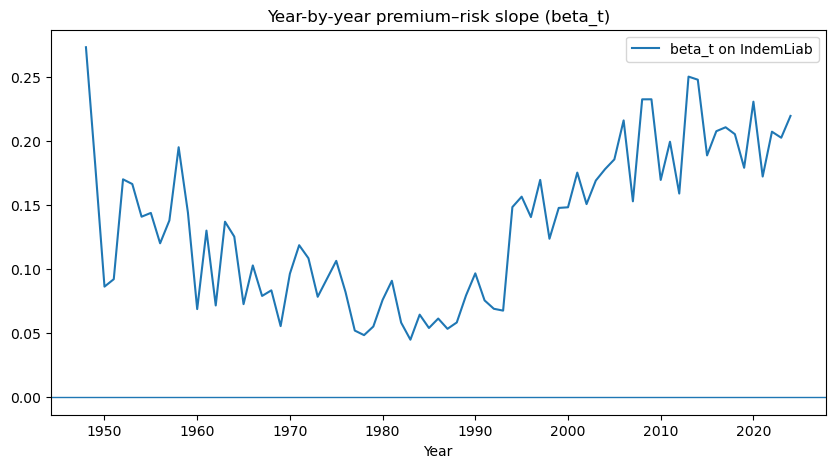

Mean beta (NW lags=6): 0.1344  SE: 0.0153  t: 8.81


In [162]:
def ols_params(df_: pd.DataFrame, formula: str) -> pd.Series:
    return smf.ols(formula, data=df_, missing="drop").fit().params

def ols_tstats(df_: pd.DataFrame, formula: str) -> pd.Series:
    return smf.ols(formula, data=df_, missing="drop").fit().tvalues

def newey_west_mean_tstat(x: pd.Series, lags: int = 6) -> tuple[float, float, float]:
    """Return (mean, se_NW, t_NW) for a series of coefficient estimates."""
    y = x.dropna().values
    X = np.ones((len(y), 1))
    mod = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": lags})
    mean = float(mod.params[0])
    se = float(mod.bse[0])
    t = float(mod.tvalues[0])
    return mean, se, t

WINSOR = 0.01   # set to 0.01 for 1% winsorization, etc.
NW_LAGS = 6

fm = df_agg[["YEAR","COUNTYCODE","CommodityCode","PremLiab","IndemLiab"]].copy()

# Winsorize within year (applied column-wise)
fm[["PremLiab","IndemLiab"]] = (
    fm.groupby("YEAR")[["PremLiab","IndemLiab"]]
      .transform(lambda s: winsorize(s, limits=[WINSOR, WINSOR]))
)

fm = fm.replace([np.inf, -np.inf], np.nan)

beta_t = fm.groupby("YEAR").apply(ols_params, "PremLiab ~ 1 + IndemLiab")
tstat_t = fm.groupby("YEAR").apply(ols_tstats, "PremLiab ~ 1 + IndemLiab")

plt.title("Year-by-year premium–risk slope (beta_t)")
plt.plot(beta_t.index, beta_t["IndemLiab"], label="beta_t on IndemLiab")
plt.axhline(0, linewidth=1)
plt.xlabel("Year")
plt.legend()
plt.show()

mean_beta, se_beta, t_beta = newey_west_mean_tstat(beta_t["IndemLiab"], lags=NW_LAGS)
print(f"Mean beta (NW lags={NW_LAGS}): {mean_beta:.4f}  SE: {se_beta:.4f}  t: {t_beta:.2f}")


### 13.1 Crop and county “fixed effect” adjustments

Premiums and losses differ systematically across crops (corn vs wheat) and across counties (climate, soil, etc.). A quick way to partial out those differences is to *demean* within crop-year or county-year.

- **Crop adjustment:** subtract crop-year means
- **County adjustment:** subtract county-year means

These are not full fixed effects (because we are running year-by-year cross-sections), but they mimic the intuition: “compare units relative to peers in the same crop (or county) that year.”


C:\Users\mlkelly0906\AppData\Local\Temp\ipykernel_18852\325585346.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  beta_crop = fm_crop.groupby("YEAR").apply(ols_params, "PremLiab_dm ~ 1 + IndemLiab_dm")
C:\Users\mlkelly0906\AppData\Local\Temp\ipykernel_18852\325585346.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  beta_county = fm_county.groupby("YEAR").apply(ols_params, "PremLiab_dm ~ 1 + IndemLi

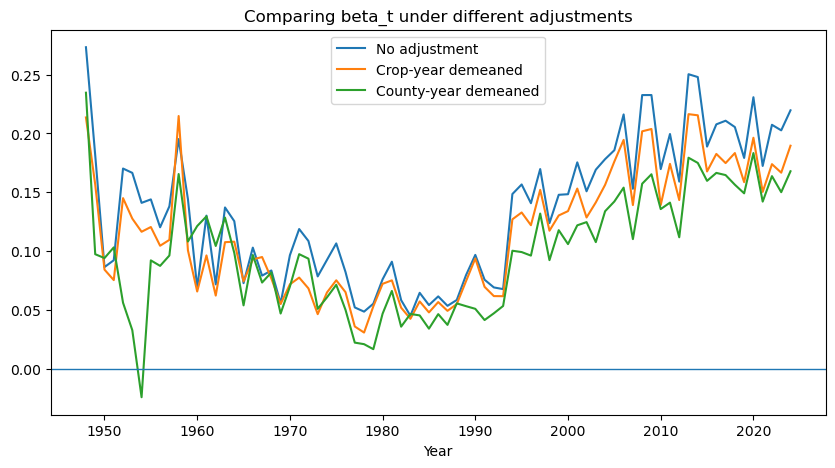

Mean betas with NW standard errors and t-stats:
No adjustment   : (0.13440991919526624, 0.015262101248781303, 8.806776799885208)
Crop demeaned   : (0.11558955363920326, 0.013552454057185281, 8.529049657830763)
County demeaned : (0.09864048563230944, 0.012242083902043935, 8.05749138966777)


In [169]:
def demean_within(df_: pd.DataFrame, group_cols: list[str], cols: list[str]) -> pd.DataFrame:
    out = df_.copy()
    g = out.groupby(group_cols)[cols].transform("mean")
    for c in cols:
        out[c + "_dm"] = out[c] - g[c]
    return out

# Crop-year demeaned
fm_crop = demean_within(fm, ["CommodityCode","YEAR"], ["PremLiab","IndemLiab"]).dropna(subset=["PremLiab_dm","IndemLiab_dm"])
beta_crop = fm_crop.groupby("YEAR").apply(ols_params, "PremLiab_dm ~ 1 + IndemLiab_dm")

# County-year demeaned
fm_county = demean_within(fm, ["COUNTYCODE","YEAR"], ["PremLiab","IndemLiab"]).dropna(subset=["PremLiab_dm","IndemLiab_dm"])
beta_county = fm_county.groupby("YEAR").apply(ols_params, "PremLiab_dm ~ 1 + IndemLiab_dm")

plt.title("Comparing beta_t under different adjustments")
plt.plot(beta_t.index, beta_t["IndemLiab"], label="No adjustment")
plt.plot(beta_crop.index, beta_crop["IndemLiab_dm"], label="Crop-year demeaned")
plt.plot(beta_county.index, beta_county["IndemLiab_dm"], label="County-year demeaned")
plt.axhline(0, linewidth=1)
plt.xlabel("Year")
plt.legend()
plt.show()

print("Mean betas with NW standard errors and t-stats:")
print("No adjustment   :", newey_west_mean_tstat(beta_t["IndemLiab"], lags=NW_LAGS))
print("Crop demeaned   :", newey_west_mean_tstat(beta_crop["IndemLiab_dm"], lags=NW_LAGS))
print("County demeaned :", newey_west_mean_tstat(beta_county["IndemLiab_dm"], lags=NW_LAGS))


## 14. Correlation structure and network graphs (advanced/optional)

Sometimes the interesting question is not just “does premium reflect risk?” but:

- Are counties’ loss rates correlated over time?
- Do some counties act like “hubs” in correlation space?
- Are there “clusters” of counties or crops that move together?

A simple way to explore this is:

1. Create a county-by-year matrix of a variable (e.g., `IndemLiab`)
2. Standardize each county series
3. Compute the correlation matrix across counties
4. Threshold correlations to build a sparse network
5. Compute centrality measures (degree, PageRank, betweenness)

> Warning: County-level correlation matrices can be large. Consider subsetting years or a region first.


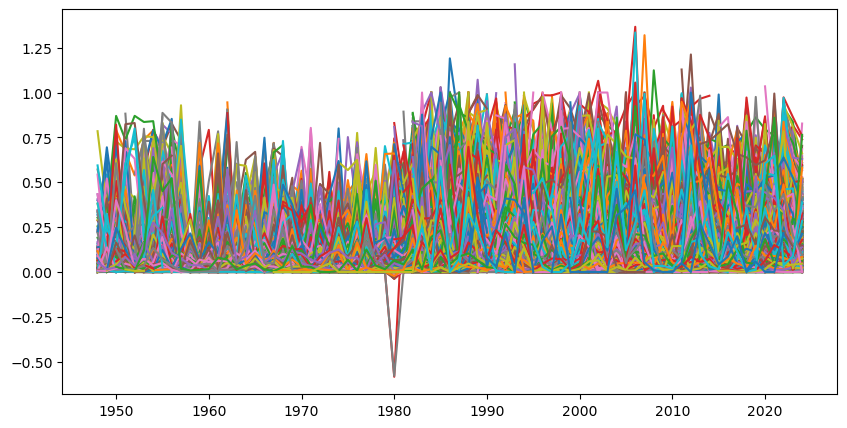

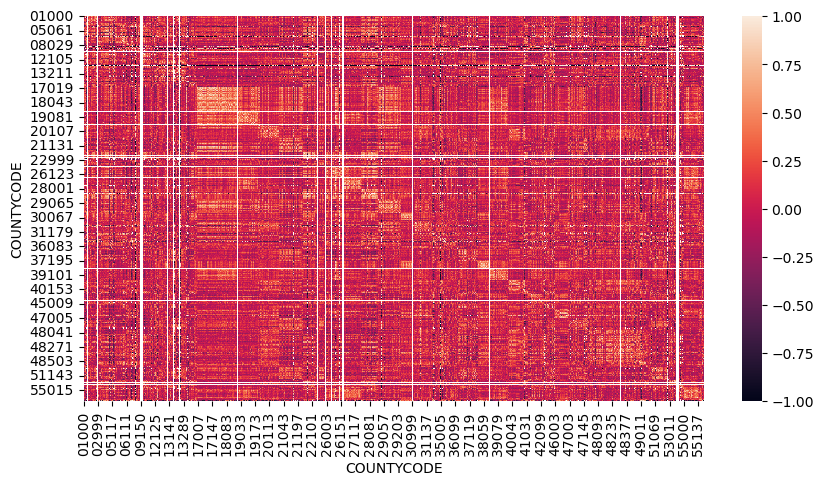

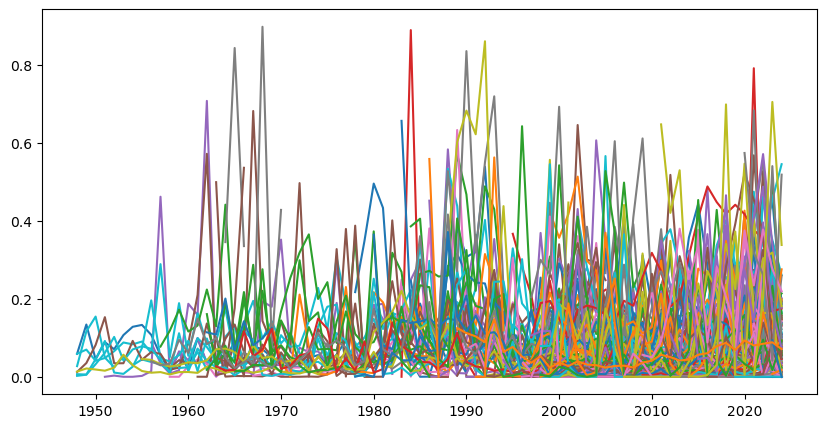

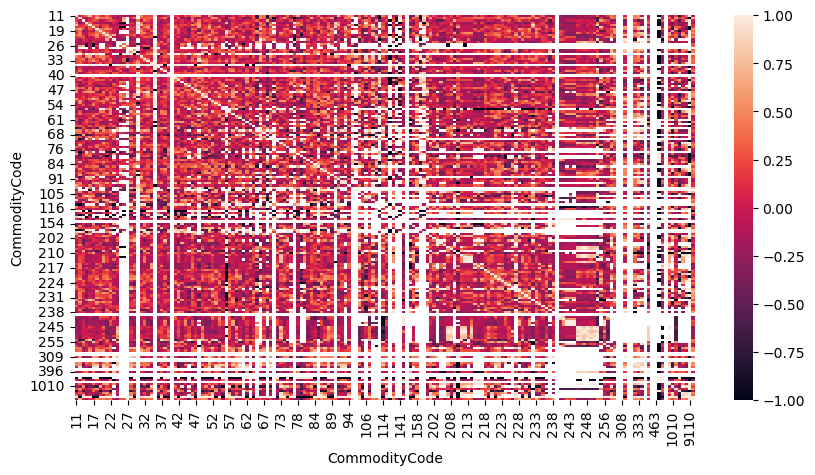

In [192]:
############
###COUNTY
############
df_aggregated = df.groupby(['COUNTYCODE','YEAR'])[['Liabilities','Premiums','Indemnities','PoliciesSoldCount','Subsidy']].sum()                     #by county
df_agg1 = df_aggregated.reset_index()
df_agg1['Indemnities']=df_agg1['Indemnities'].astype(float)
df_agg1['Liabilities']=df_agg1['Liabilities'].astype(float)
df_agg1['Premiums']=df_agg1['Premiums'].astype(float)
df_agg1['Subsidy']=df_agg1['Subsidy'].astype(float)
#Make per Liability variables
df_agg1['IndemLiab']=df_agg1['Indemnities']/df_agg1['Liabilities']
df_agg1['IndemLiab'].isna().sum()
df_agg1['PremLiab']=df_agg1['Premiums']/df_agg1['Liabilities']
df_agg1['PremLiab'].isna().sum()
df_agg1['SubLiab']=df_agg1['Subsidy']/df_agg1['Liabilities']
df_agg1['SubLiab'].isna().sum()
df_agg1['SubPrem']=df_agg1['Subsidy']/df_agg1['Premiums']
df_agg1['SubPrem'].isna().sum()
df_indexed = df_agg1.set_index(['COUNTYCODE','YEAR'])

#indemnities
df_unstacked_county = df_indexed['IndemLiab'].unstack(level='COUNTYCODE')
plt.plot(df_unstacked_county)
plt.show()
df_unstacked_county_z = (df_unstacked_county-df_unstacked_county.mean())/df_unstacked_county.std()
sns.heatmap(df_unstacked_county_z.corr())
plt.show()



############
###Crop
############
df_aggregated = df.groupby(['CommodityCode','YEAR'])[['Liabilities','Premiums','Indemnities','PoliciesSoldCount','Subsidy']].sum()                  #by crop
df_agg2 = df_aggregated.reset_index()
df_agg2['Indemnities']=df_agg2['Indemnities'].astype(float)
df_agg2['Liabilities']=df_agg2['Liabilities'].astype(float)
df_agg2['Premiums']=df_agg2['Premiums'].astype(float)
df_agg2['Subsidy']=df_agg2['Subsidy'].astype(float)
#Make per Liability variables
df_agg2['IndemLiab']=df_agg2['Indemnities']/df_agg2['Liabilities']
df_agg2['IndemLiab'].isna().sum()
df_agg2['PremLiab']=df_agg2['Premiums']/df_agg2['Liabilities']
df_agg2['PremLiab'].isna().sum()
df_agg2['SubLiab']=df_agg2['Subsidy']/df_agg2['Liabilities']
df_agg2['SubLiab'].isna().sum()
df_agg2['SubPrem']=df_agg2['Subsidy']/df_agg2['Premiums']
df_agg2['SubPrem'].isna().sum()
df_indexed = df_agg2.set_index(['CommodityCode','YEAR'])

#Indemnities
df_unstacked_crop = df_indexed['IndemLiab'].unstack(level='CommodityCode')
plt.plot(df_unstacked_crop)
plt.show()
df_unstacked_crop_z = (df_unstacked_crop-df_unstacked_crop.mean())/df_unstacked_crop.std()
sns.heatmap(df_unstacked_crop_z.corr())
plt.show()

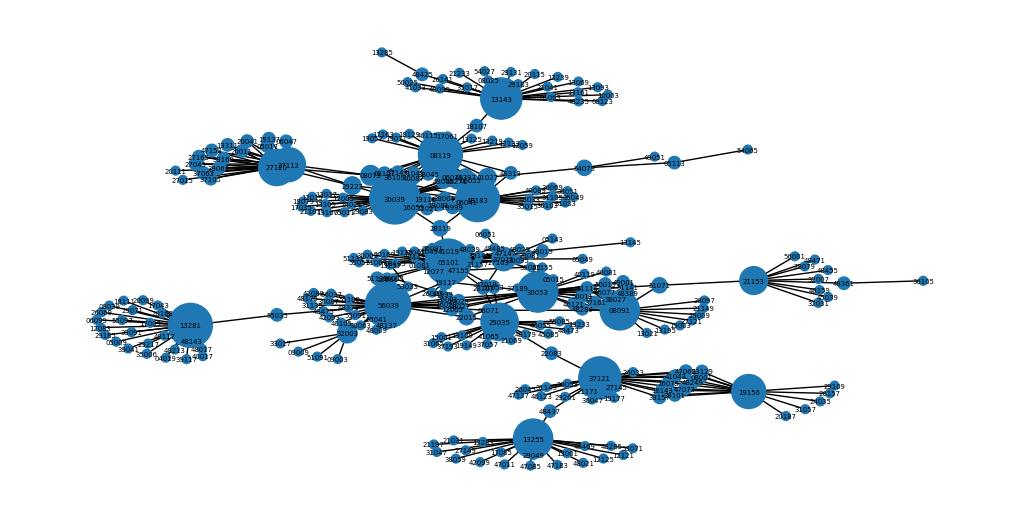

C:\Users\mlkelly0906\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


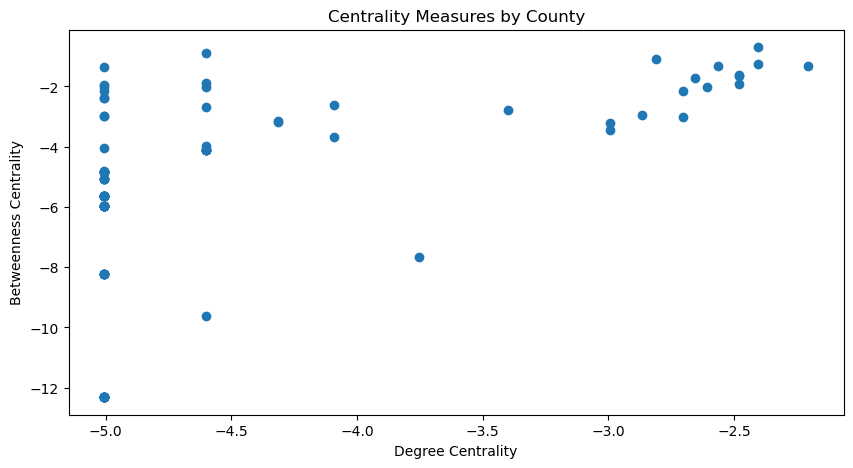

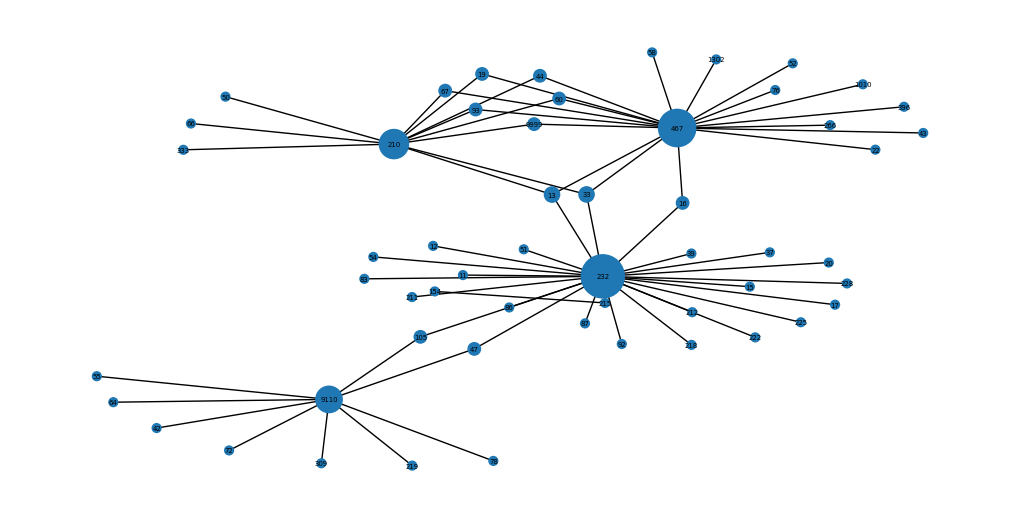

C:\Users\mlkelly0906\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


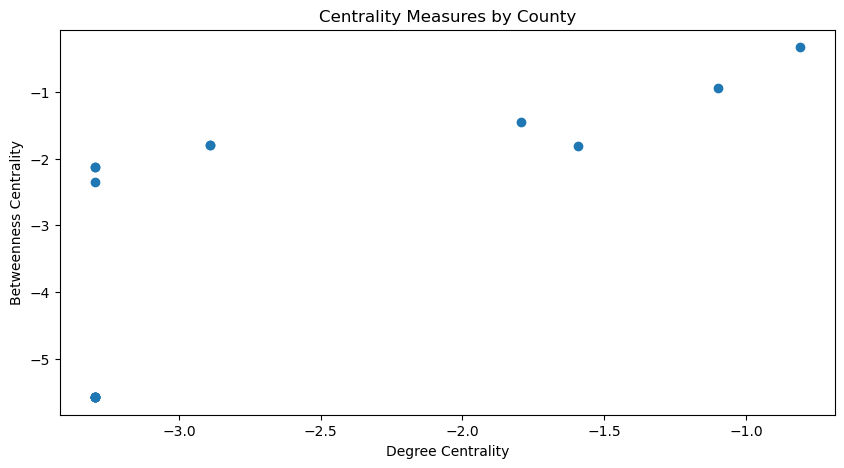

In [194]:
########################
#NETWORK GRAPHS
########################


############
###COUNTY
############
# Calculate the correlation between individuals. We have to transpose first, because the corr function calculate the pairwise correlations between columns.
corr = df_unstacked_county[df_unstacked_county.index > 2010].corr()
# Transform it in a links data frame (3 columns only):
links = corr.stack()
links.index.names = ['COUNTYCODE','COUNTYCODE2']
links = links.reset_index()
links.columns = ['var1', 'var2', 'value']
# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ ((links['value']) > links['value'].quantile(.9999)) & (links['var1'] != links['var2']) ]  #positive corr network
links_filtered=links.loc[ ((links['value']) < links['value'].quantile(.0001)) & (links['var1'] != links['var2']) ]  #negative corr network

# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')
d = dict(G.degree)
# Plot the network:
nx.draw_kamada_kawai(G, with_labels=True, font_weight='normal', node_size=[v * 40 for v in d.values()], font_size=5)
plt.show()

############ centrality measures, tables/heatmaps
#evc = pd.DataFrame.from_dict(nx.eigenvector_centrality(G),orient='index')
#evc = evc.rename(columns = {0: 'Eigenvalue Centrality'})
#evc = evc.rank(numeric_only = True)
pr = pd.DataFrame.from_dict(nx.pagerank(G),orient='index')
pr = pr.rename(columns = {0: 'Page Rank'})
#Tablen = pd.merge(evc,pr,how='inner',left_index=True,right_index=True)
dc = pd.DataFrame.from_dict(nx.degree_centrality(G),orient='index')
dc = dc.rename(columns = {0: 'Degree Centrality'})
Tablen = pd.merge(pr,dc,how='inner',left_index=True,right_index=True)
bc = pd.DataFrame.from_dict(nx.betweenness_centrality(G),orient='index')
bc = bc.rename(columns = {0: 'Betweenness Centrality'})
Tablen1 = pd.merge(Tablen,bc,how='inner',left_index=True,right_index=True)
Tablen1.sort_values(by='Degree Centrality')

#Plot of Centrality Measures
plt.title('Centrality Measures by County')
plt.scatter(np.log(Tablen1['Degree Centrality']),np.log(Tablen1['Betweenness Centrality']))
plt.xlabel('Degree Centrality')
plt.ylabel('Betweenness Centrality')
plt.show()




############
###CROP
############
# Calculate the correlation between individuals. We have to transpose first, because the corr function calculate the pairwise correlations between columns.
corr = df_unstacked_crop[df_unstacked_crop.index > 2010].corr()
# Transform it in a links data frame (3 columns only):
links = corr.stack()
links.index.names = ['CommidityCode1','CommodityCode2']
links = links.reset_index()
links.columns = ['var1', 'var2', 'value']
# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ ((links['value']) > links['value'].quantile(.99)) & (links['var1'] != links['var2']) ]    #postive corr network
links_filtered=links.loc[ ((links['value']) < links['value'].quantile(.01)) & (links['var1'] != links['var2']) ]    #negative corr network

# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')
d = dict(G.degree)
# Plot the network:
nx.draw_kamada_kawai(G, with_labels=True, font_weight='normal', node_size=[v * 40 for v in d.values()], font_size=5)
plt.show()

############ centrality measures, tables/heatmaps
#evc = pd.DataFrame.from_dict(nx.eigenvector_centrality(G),orient='index')
#evc = evc.rename(columns = {0: 'Eigenvalue Centrality'})
#evc = evc.rank(numeric_only = True)
pr = pd.DataFrame.from_dict(nx.pagerank(G),orient='index')
pr = pr.rename(columns = {0: 'Page Rank'})
#Tablen = pd.merge(evc,pr,how='inner',left_index=True,right_index=True)
dc = pd.DataFrame.from_dict(nx.degree_centrality(G),orient='index')
dc = dc.rename(columns = {0: 'Degree Centrality'})
Tablen = pd.merge(pr,dc,how='inner',left_index=True,right_index=True)
bc = pd.DataFrame.from_dict(nx.betweenness_centrality(G),orient='index')
bc = bc.rename(columns = {0: 'Betweenness Centrality'})
Tablen1 = pd.merge(Tablen,bc,how='inner',left_index=True,right_index=True)
Tablen1.sort_values(by='Degree Centrality')

#Plot of Centrality Measures
plt.title('Centrality Measures by County')
plt.scatter(np.log(Tablen1['Degree Centrality']),np.log(Tablen1['Betweenness Centrality']))
plt.xlabel('Degree Centrality')
plt.ylabel('Betweenness Centrality')
plt.show()

## 15. Weather merge (optional)

If you have county-year weather data, you can enrich the panel and ask:

- Are premiums higher in hotter or more volatile climates?
- Does controlling for weather weaken or strengthen the premium–risk relationship?

The original script used county-year CSVs with monthly columns like:

- `JAN_maxtemp`, …, `DEC_maxtemp`
- `JAN_precip`, …, `DEC_precip`

and then created summary features like annual mean and annual standard deviation.

Below is a reusable pattern for feature creation + merging.  
If you don’t have weather data, skip this section.


In [ ]:
#set file paths (insert your file paths here)
file_path_maxtemp = r'C:\Users\...\weather data\Max Temp (1).csv'
file_path_mintemp = r'C:\Users\...\weather data\Min Temp (1).csv'
file_path_meantemp = r'C:\Users\...\weather data\Mean Temp (1).csv'
file_path_precip = r'C:\Users\...\weather data\Precipitation (1).csv'

In [203]:
#################
#WEATHER DATA
#################

#load data
#MAX
maxtemp = pd.read_csv(file_path_maxtemp)
maxtemp['mean_maxtemp'] = maxtemp[['JAN_maxtemp','FEB_maxtemp','MAR_maxtemp','APR_maxtemp','MAY_maxtemp','JUNE_maxtemp','JULY_maxtemp','AUG_maxtemp','SEPT_maxtemp','OCT_maxtemp','NOV_maxtemp','DEC_maxtemp']].mean(axis=1)
maxtemp['std_maxtemp'] = maxtemp[['JAN_maxtemp','FEB_maxtemp','MAR_maxtemp','APR_maxtemp','MAY_maxtemp','JUNE_maxtemp','JULY_maxtemp','AUG_maxtemp','SEPT_maxtemp','OCT_maxtemp','NOV_maxtemp','DEC_maxtemp']].std(axis=1)
maxtemp['range_maxtemp'] = maxtemp[['JAN_maxtemp','FEB_maxtemp','MAR_maxtemp','APR_maxtemp','MAY_maxtemp','JUNE_maxtemp','JULY_maxtemp','AUG_maxtemp','SEPT_maxtemp','OCT_maxtemp','NOV_maxtemp','DEC_maxtemp']].max(axis=1)-maxtemp[['JAN_maxtemp','FEB_maxtemp','MAR_maxtemp','APR_maxtemp','MAY_maxtemp','JUNE_maxtemp','JULY_maxtemp','AUG_maxtemp','SEPT_maxtemp','OCT_maxtemp','NOV_maxtemp','DEC_maxtemp']].min(axis=1)
maxtemp['median_maxtemp'] = maxtemp[['JAN_maxtemp','FEB_maxtemp','MAR_maxtemp','APR_maxtemp','MAY_maxtemp','JUNE_maxtemp','JULY_maxtemp','AUG_maxtemp','SEPT_maxtemp','OCT_maxtemp','NOV_maxtemp','DEC_maxtemp']].median(axis=1)
maxtemp['COUNTYCODE']=maxtemp['COUNTYCODE'].astype(str).str.zfill(5)
#MIN
mintemp = pd.read_csv(file_path_mintemp)
mintemp['mean_mintemp'] = mintemp[['JAN_mintemp','FEB_mintemp','MAR_mintemp','APR_mintemp','MAY_mintemp','JUNE_mintemp','JULY_mintemp','AUG_mintemp','SEPT_mintemp','OCT_mintemp','NOV_mintemp','DEC_mintemp']].mean(axis=1)
mintemp['std_mintemp'] = mintemp[['JAN_mintemp','FEB_mintemp','MAR_mintemp','APR_mintemp','MAY_mintemp','JUNE_mintemp','JULY_mintemp','AUG_mintemp','SEPT_mintemp','OCT_mintemp','NOV_mintemp','DEC_mintemp']].std(axis=1)
mintemp['range_mintemp'] = mintemp[['JAN_mintemp','FEB_mintemp','MAR_mintemp','APR_mintemp','MAY_mintemp','JUNE_mintemp','JULY_mintemp','AUG_mintemp','SEPT_mintemp','OCT_mintemp','NOV_mintemp','DEC_mintemp']].max(axis=1)-mintemp[['JAN_mintemp','FEB_mintemp','MAR_mintemp','APR_mintemp','MAY_mintemp','JUNE_mintemp','JULY_mintemp','AUG_mintemp','SEPT_mintemp','OCT_mintemp','NOV_mintemp','DEC_mintemp']].min(axis=1)
mintemp['median_mintemp'] = mintemp[['JAN_mintemp','FEB_mintemp','MAR_mintemp','APR_mintemp','MAY_mintemp','JUNE_mintemp','JULY_mintemp','AUG_mintemp','SEPT_mintemp','OCT_mintemp','NOV_mintemp','DEC_mintemp']].median(axis=1)
mintemp['COUNTYCODE']=mintemp['COUNTYCODE'].astype(str).str.zfill(5)
#MEAN
meantemp = pd.read_csv(file_path_meantemp)
meantemp['mean_meantemp'] = meantemp[['JAN_meantemp','FEB_meantemp','MAR_meantemp','APR_meantemp','MAY_meantemp','JUNE_meantemp','JULY_meantemp','AUG_meantemp','SEPT_meantemp','OCT_meantemp','NOV_meantemp','DEC_meantemp']].mean(axis=1)
meantemp['std_meantemp'] = meantemp[['JAN_meantemp','FEB_meantemp','MAR_meantemp','APR_meantemp','MAY_meantemp','JUNE_meantemp','JULY_meantemp','AUG_meantemp','SEPT_meantemp','OCT_meantemp','NOV_meantemp','DEC_meantemp']].std(axis=1)
meantemp['range_meantemp'] = meantemp[['JAN_meantemp','FEB_meantemp','MAR_meantemp','APR_meantemp','MAY_meantemp','JUNE_meantemp','JULY_meantemp','AUG_meantemp','SEPT_meantemp','OCT_meantemp','NOV_meantemp','DEC_meantemp']].max(axis=1)-meantemp[['JAN_meantemp','FEB_meantemp','MAR_meantemp','APR_meantemp','MAY_meantemp','JUNE_meantemp','JULY_meantemp','AUG_meantemp','SEPT_meantemp','OCT_meantemp','NOV_meantemp','DEC_meantemp']].min(axis=1)
meantemp['median_meantemp'] = meantemp[['JAN_meantemp','FEB_meantemp','MAR_meantemp','APR_meantemp','MAY_meantemp','JUNE_meantemp','JULY_meantemp','AUG_meantemp','SEPT_meantemp','OCT_meantemp','NOV_meantemp','DEC_meantemp']].median(axis=1)
meantemp['COUNTYCODE']=meantemp['COUNTYCODE'].astype(str).str.zfill(5)
#PRECIPITATION
precip = pd.read_csv(file_path_precip)
precip['mean_precip'] = precip[['JAN_precip','FEB_precip','MAR_precip','APR_precip','MAY_precip','JUNE_precip','JULY_precip','AUG_precip','SEPT_precip','OCT_precip','NOV_precip','DEC_precip']].mean(axis=1)
precip['std_precip'] = precip[['JAN_precip','FEB_precip','MAR_precip','APR_precip','MAY_precip','JUNE_precip','JULY_precip','AUG_precip','SEPT_precip','OCT_precip','NOV_precip','DEC_precip']].std(axis=1)
precip['range_precip'] = precip[['JAN_precip','FEB_precip','MAR_precip','APR_precip','MAY_precip','JUNE_precip','JULY_precip','AUG_precip','SEPT_precip','OCT_precip','NOV_precip','DEC_precip']].max(axis=1)-precip[['JAN_precip','FEB_precip','MAR_precip','APR_precip','MAY_precip','JUNE_precip','JULY_precip','AUG_precip','SEPT_precip','OCT_precip','NOV_precip','DEC_precip']].min(axis=1)
precip['median_precip'] = precip[['JAN_precip','FEB_precip','MAR_precip','APR_precip','MAY_precip','JUNE_precip','JULY_precip','AUG_precip','SEPT_precip','OCT_precip','NOV_precip','DEC_precip']].median(axis=1)
precip['COUNTYCODE']=precip['COUNTYCODE'].astype(str).str.zfill(5)
#MERGE
df_merged = pd.merge(df_agg,maxtemp,on=['COUNTYCODE','YEAR'],how='outer')
df_merged = pd.merge(df_merged,mintemp,on=['COUNTYCODE','YEAR'],how='outer')
df_merged = pd.merge(df_merged,meantemp,on=['COUNTYCODE','YEAR'],how='outer')
df_merged = pd.merge(df_merged,precip,on=['COUNTYCODE','YEAR'],how='outer')
df_merged_test = df_merged.head()


### 15.1 Seasonality of Weather

Weather is the quintessential seasonal data. The following plots illustrate how much these weather variables change over the course of the year, as well as how statistical cross-sectional moments across counties have changed over time.

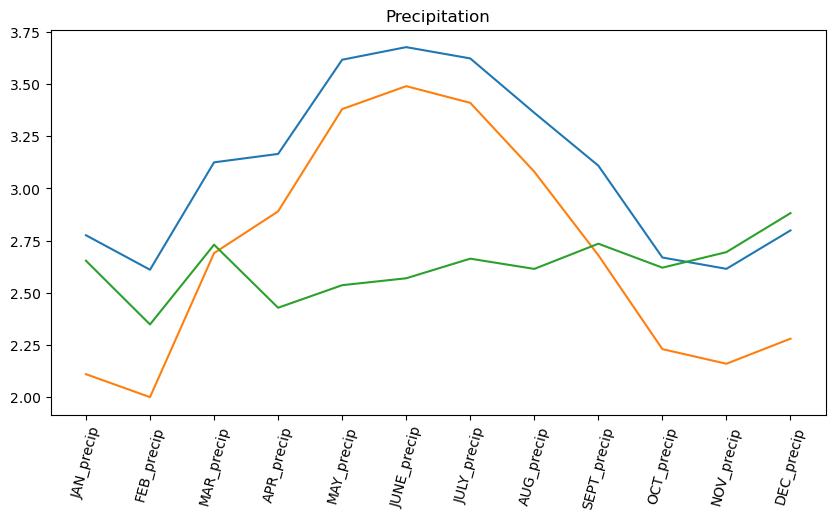

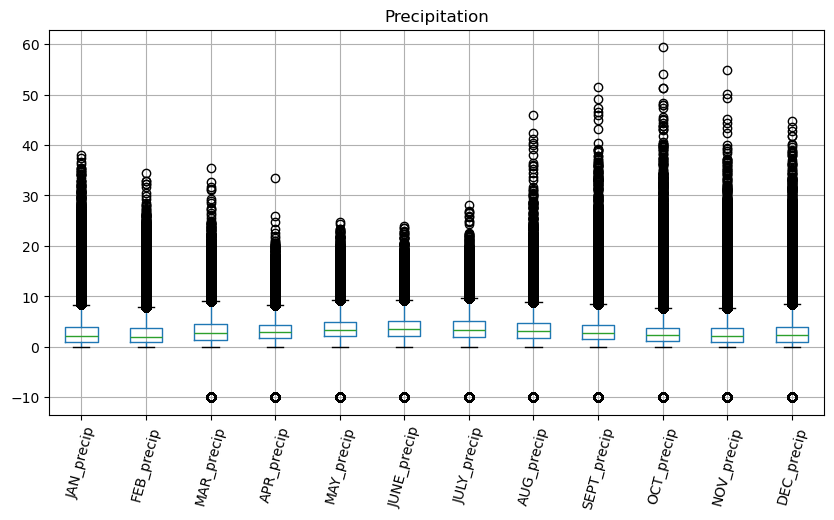

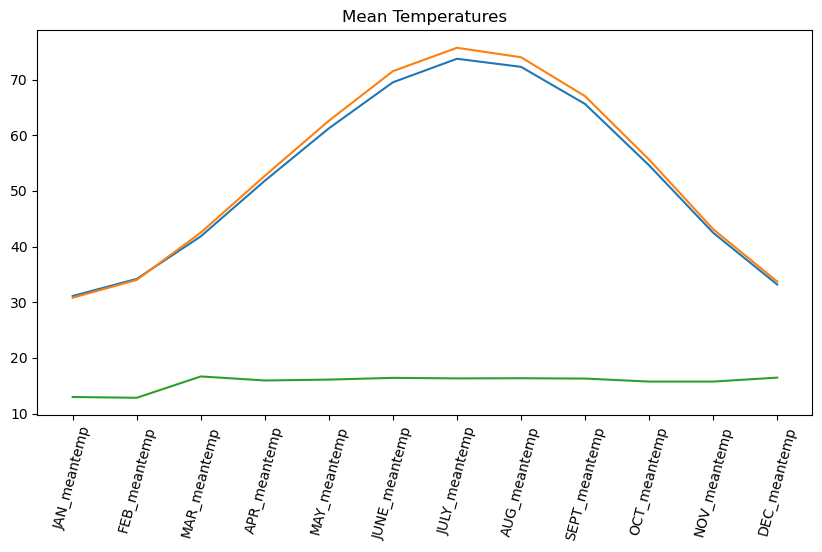

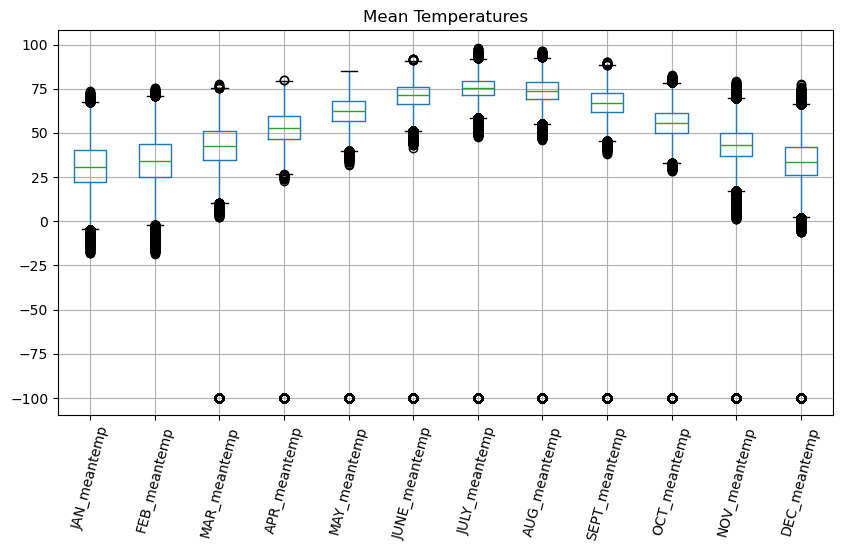

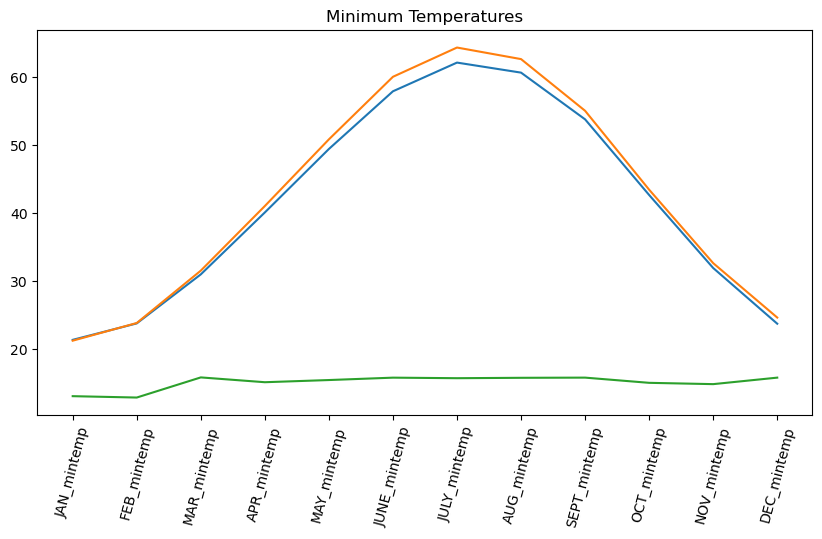

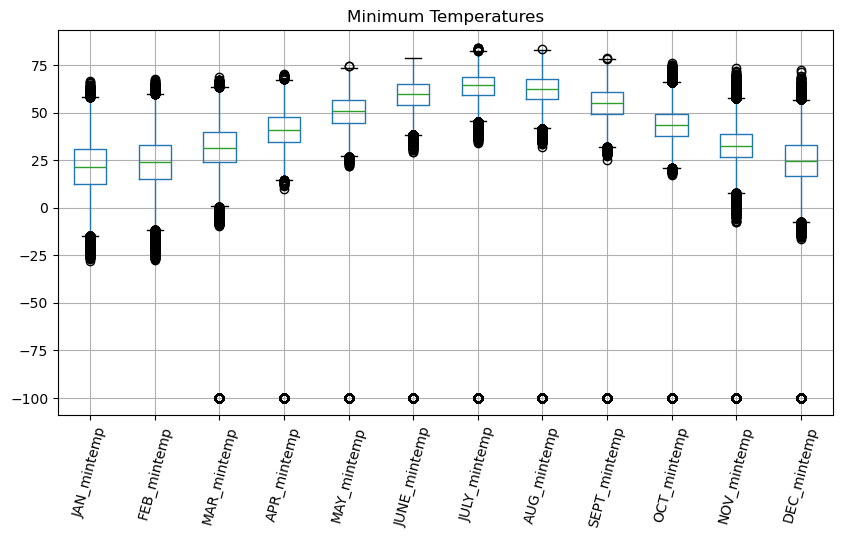

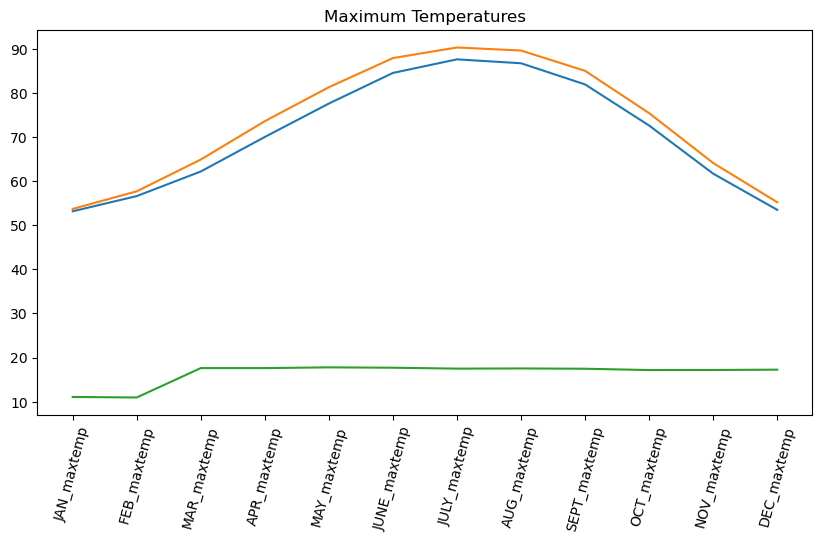

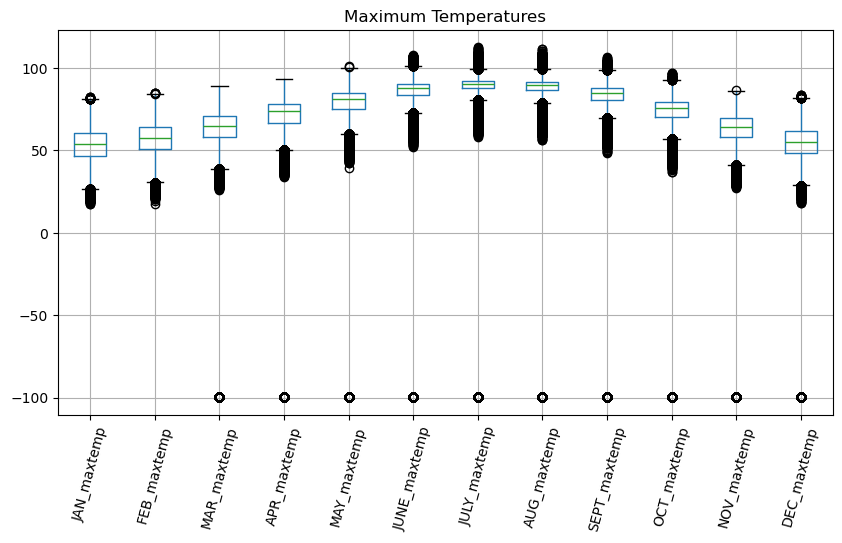

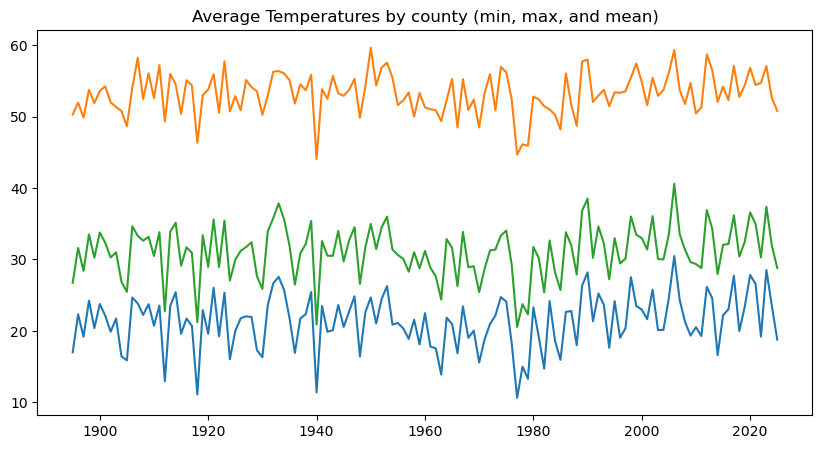

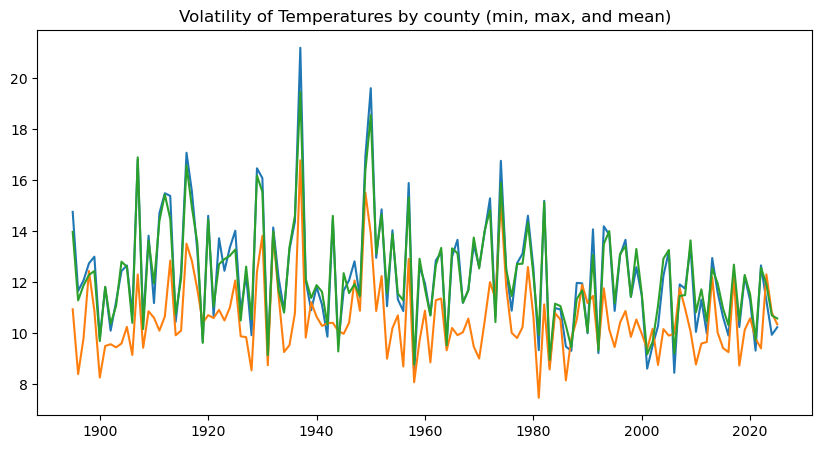

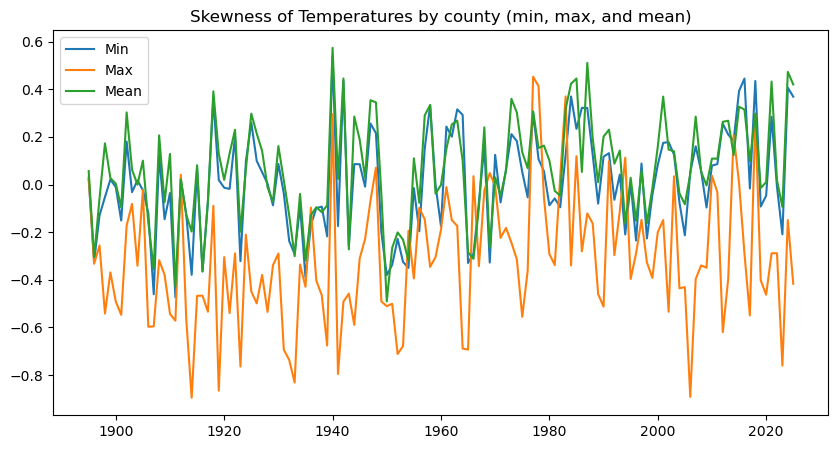

In [213]:
#######################
# SEASONALITY of weather
#######################
#Precipitation
plt.title('Precipitation')
plt.plot(precip[['JAN_precip','FEB_precip','MAR_precip','APR_precip','MAY_precip','JUNE_precip','JULY_precip','AUG_precip','SEPT_precip','OCT_precip','NOV_precip','DEC_precip']].mean())
plt.plot(precip[['JAN_precip','FEB_precip','MAR_precip','APR_precip','MAY_precip','JUNE_precip','JULY_precip','AUG_precip','SEPT_precip','OCT_precip','NOV_precip','DEC_precip']].median())
plt.plot(precip[['JAN_precip','FEB_precip','MAR_precip','APR_precip','MAY_precip','JUNE_precip','JULY_precip','AUG_precip','SEPT_precip','OCT_precip','NOV_precip','DEC_precip']].std())
plt.xticks(rotation=75)
plt.show()
plt.title('Precipitation')
precip[['JAN_precip','FEB_precip','MAR_precip','APR_precip','MAY_precip','JUNE_precip','JULY_precip','AUG_precip','SEPT_precip','OCT_precip','NOV_precip','DEC_precip']].boxplot()
plt.xticks(rotation=75)
plt.show()
#Mean Temperature
plt.title('Mean Temperatures')
plt.plot(meantemp[['JAN_meantemp','FEB_meantemp','MAR_meantemp','APR_meantemp','MAY_meantemp','JUNE_meantemp','JULY_meantemp','AUG_meantemp','SEPT_meantemp','OCT_meantemp','NOV_meantemp','DEC_meantemp']].mean())
plt.plot(meantemp[['JAN_meantemp','FEB_meantemp','MAR_meantemp','APR_meantemp','MAY_meantemp','JUNE_meantemp','JULY_meantemp','AUG_meantemp','SEPT_meantemp','OCT_meantemp','NOV_meantemp','DEC_meantemp']].median())
plt.plot(meantemp[['JAN_meantemp','FEB_meantemp','MAR_meantemp','APR_meantemp','MAY_meantemp','JUNE_meantemp','JULY_meantemp','AUG_meantemp','SEPT_meantemp','OCT_meantemp','NOV_meantemp','DEC_meantemp']].std())
plt.xticks(rotation=75)
plt.show()
plt.title('Mean Temperatures')
meantemp[['JAN_meantemp','FEB_meantemp','MAR_meantemp','APR_meantemp','MAY_meantemp','JUNE_meantemp','JULY_meantemp','AUG_meantemp','SEPT_meantemp','OCT_meantemp','NOV_meantemp','DEC_meantemp']].boxplot()
plt.xticks(rotation=75)
plt.show()
#Minimum Temperatures
plt.title('Minimum Temperatures')
plt.plot(mintemp[['JAN_mintemp','FEB_mintemp','MAR_mintemp','APR_mintemp','MAY_mintemp','JUNE_mintemp','JULY_mintemp','AUG_mintemp','SEPT_mintemp','OCT_mintemp','NOV_mintemp','DEC_mintemp']].mean())
plt.plot(mintemp[['JAN_mintemp','FEB_mintemp','MAR_mintemp','APR_mintemp','MAY_mintemp','JUNE_mintemp','JULY_mintemp','AUG_mintemp','SEPT_mintemp','OCT_mintemp','NOV_mintemp','DEC_mintemp']].median())
plt.plot(mintemp[['JAN_mintemp','FEB_mintemp','MAR_mintemp','APR_mintemp','MAY_mintemp','JUNE_mintemp','JULY_mintemp','AUG_mintemp','SEPT_mintemp','OCT_mintemp','NOV_mintemp','DEC_mintemp']].std())
plt.xticks(rotation=75)
plt.show()
plt.title('Minimum Temperatures')
mintemp[['JAN_mintemp','FEB_mintemp','MAR_mintemp','APR_mintemp','MAY_mintemp','JUNE_mintemp','JULY_mintemp','AUG_mintemp','SEPT_mintemp','OCT_mintemp','NOV_mintemp','DEC_mintemp']].boxplot()
plt.xticks(rotation=75)
plt.show()
#Maximum Temperatures
plt.title('Maximum Temperatures')
plt.plot(maxtemp[['JAN_maxtemp','FEB_maxtemp','MAR_maxtemp','APR_maxtemp','MAY_maxtemp','JUNE_maxtemp','JULY_maxtemp','AUG_maxtemp','SEPT_maxtemp','OCT_maxtemp','NOV_maxtemp','DEC_maxtemp']].mean())
plt.plot(maxtemp[['JAN_maxtemp','FEB_maxtemp','MAR_maxtemp','APR_maxtemp','MAY_maxtemp','JUNE_maxtemp','JULY_maxtemp','AUG_maxtemp','SEPT_maxtemp','OCT_maxtemp','NOV_maxtemp','DEC_maxtemp']].median())
plt.plot(maxtemp[['JAN_maxtemp','FEB_maxtemp','MAR_maxtemp','APR_maxtemp','MAY_maxtemp','JUNE_maxtemp','JULY_maxtemp','AUG_maxtemp','SEPT_maxtemp','OCT_maxtemp','NOV_maxtemp','DEC_maxtemp']].std())
plt.xticks(rotation=75)
plt.show()
plt.title('Maximum Temperatures')
maxtemp[['JAN_maxtemp','FEB_maxtemp','MAR_maxtemp','APR_maxtemp','MAY_maxtemp','JUNE_maxtemp','JULY_maxtemp','AUG_maxtemp','SEPT_maxtemp','OCT_maxtemp','NOV_maxtemp','DEC_maxtemp']].boxplot()
plt.xticks(rotation=75)
plt.show()

###################
# Trends in weather
###################
#Average temps
plt.title('Average Temperatures by county (min, max, and mean)')
plt.plot(mintemp.groupby('YEAR')['JAN_mintemp'].mean(),label='Min')
plt.plot(maxtemp.groupby('YEAR')['JAN_maxtemp'].mean(),label='Max')
plt.plot(meantemp.groupby('YEAR')['JAN_meantemp'].mean(),label='Mean')
plt.show()
#volatility of temps
plt.title('Volatility of Temperatures by county (min, max, and mean)')
plt.plot(mintemp.groupby('YEAR')['JAN_mintemp'].std(),label='Min')
plt.plot(maxtemp.groupby('YEAR')['JAN_maxtemp'].std(),label='Max')
plt.plot(meantemp.groupby('YEAR')['JAN_meantemp'].std(),label='Mean')
plt.show()
#skewness of temps
plt.title('Skewness of Temperatures by county (min, max, and mean)')
plt.plot(mintemp.groupby('YEAR')['JAN_mintemp'].skew(),label='Min')
plt.plot(maxtemp.groupby('YEAR')['JAN_maxtemp'].skew(),label='Max')
plt.plot(meantemp.groupby('YEAR')['JAN_meantemp'].skew(),label='Mean')
plt.legend()
plt.show()

### 15.2 County maps (interactive)

Plotly can draw choropleth maps using county FIPS codes.  
This is a great “wow factor” for a GitHub tutorial — but it’s optional.

> If maps don’t render in your environment, try changing `pio.renderers.default` to `"browser"`.


In [211]:
#############
#MAP FIGURE
#############
df_map = df_merged[df_merged['YEAR']==2023]
df_sample = df_map #.dropna(subset='IndemLiab')
df_sample['FIPS'] = df_sample['COUNTYCODE']

pio.renderers.default = "svg"
#INSURANCE DATA MAP 1 (indemnities)
# Create the choropleth map
fig = px.choropleth(
    df_sample,
    geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",
    locations='FIPS',
    color='IndemLiab',  # Column to use for continuous color scale
    color_continuous_scale="Viridis",  # Choose a built-in continuous color scale
    scope="usa",  # Focus on the USA
    title="County Data with Continuous Color Scale"
)

fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show(renderer="browser")

#INSURANCE DATA MAP 2 (premiums)
# Create the choropleth map
fig = px.choropleth(
    df_sample,
    geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",
    locations='FIPS',
    color='PremLiab',  # Column to use for continuous color scale
    color_continuous_scale="Viridis",  # Choose a built-in continuous color scale
    scope="usa",  # Focus on the USA
    title="County Data with Continuous Color Scale"
)

fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show(renderer="browser")

#INSURANCE DATA MAP 2 (premiums)
# Create the choropleth map
fig = px.choropleth(
    df_sample,
    geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",
    locations='FIPS',
    color='Liabilities',  # Column to use for continuous color scale
    color_continuous_scale="Viridis",  # Choose a built-in continuous color scale
    scope="usa",  # Focus on the USA
    title="County Data with Continuous Color Scale"
)

fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show(renderer="browser")

#WEATHER DATA MAP
# Create the choropleth map
fig = px.choropleth(
    df_sample,
    geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",
    locations='FIPS',
    color='mean_meantemp',  # Column to use for continuous color scale
    color_continuous_scale="Viridis",  # Choose a built-in continuous color scale
    scope="usa",  # Focus on the USA
    title="County Data with Continuous Color Scale"
)

fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show(renderer="browser")

C:\Users\mlkelly0906\AppData\Local\Temp\ipykernel_18852\3885181737.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 16. Wrap-up

Now that you have the data and have performed some basic analysis, you can explore other relationships betwen variables and other topics.
